**Migrant Crisis Perception Clustering & Sentiment Analysis** <br>
Purpose: Analyzing the perception on incoming migrants to the United States using newspaper headlines and tweets. <br>
Notebook Author: Christian Sarmiento <br>
Faculty Advisor: Dr. Amanda Damiano <br>
Institution: Marist College <br>
Last Edited: 5/24/2024 <br>
Sources: <br>
- https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest?text=Covid+cases+are+increasing+fast%21
- https://chatgpt.com/
- https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
- https://datascience.stackexchange.com/questions/64455/how-to-evaluate-the-k-modes-clusters
- https://medium.com/@danielafrimi/text-clustering-using-nlp-techniques-c2e6b08b6e95
- https://www.analyticsvidhya.com/blog/2021/07/word2vec-for-word-embeddings-a-beginners-guide/


In [1]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.3 MB/s eta 0:00:00


In [2]:
!pip install kmodes

In [80]:
! pip -q install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00


In [81]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import category_encoders as ce
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec  # word vectorization for clustering
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import openai  # helping with topic modeling
from transformers import pipeline  # Sentiment analysis
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
nltk.download('stopwords')
openai.api_key = '***********************************' # API key

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Import data
newspapers = pd.read_csv('newspaper_headlines.csv')
tweets = pd.read_csv('tweets.csv')

# Take a Look at the Data

In [ ]:
newspapers.head()

,Date,Headline,https://www.nydailynews.com/2024/02/27/dozens-of-migrant-men-found-crammed-in-queens-furniture-store-basement/,Hit Sentence,Source,Reach,Desktop Reach,Mobile Reach,Sentiment,Key Phrases,...,Do they mention political affiliation?,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,27-Feb-2024 06:02PM,Dozens of migrant men found crammed in Queens ...,https://rumble.com/v4fusmi-anthony-agero-live-...,"... about New York City budget, spending cuts ...",New York Daily News,5437834.0,1142877.0,4294957.0,Neutral,"adams administration,affordable housing,baseme...",...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26-Feb-2024 03:07PM,Anthony Agüero Live back in California,https://commercialobserver.com/2024/02/new-yor...,... seconds 15 seconds Another explosive after...,Rumble,32479287.0,5795432.0,26683855.0,Neutral,"explosive afternoon,migrants crisis",...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26-Feb-2024 11:25AM,Migrants Crisis a Lifeline for New York City H...,https://newsexplorer.net/nyc-council-moves-to-...,... in the cost to shelter them. The city has ...,Commercial Observer,247198.0,87311.0,159887.0,Neutral,"adams administration,asylum seekers,budget,cit...",...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21-Feb-2024 01:03PM,NYC Council moves to join lawsuit to force May...,https://www.foxnews.com/video/6347134714112,... press conference hizzoner discussed recent...,newsexplorer.net,3762.0,3762.0,0.0,Neutral,"adams’ city hall counsel,city,city shelter pop...",...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17-Feb-2024 10:54PM,"The Big Weekend Show - Saturday, February 17",https://theweekinpolls.substack.com/p/what-doe...,"Civil fraud, Migrants crisis, Putin ...",Fox News Channel,51520443.0,11211586.0,40308857.0,Negative,"civil fraud,migrants crisis",...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
newspapers.columns

Index(['Date', 'Headline',
       'https://www.nydailynews.com/2024/02/27/dozens-of-migrant-men-found-crammed-in-queens-furniture-store-basement/',
       'Hit Sentence', 'Source', 'Reach', 'Desktop Reach', 'Mobile Reach',
       'Sentiment', 'Key Phrases', 'News Sender Category', 'Sentiment.1',
       'Do they reference crime?', 'Do they reference laws?',
       'Do they mention Housing?', 'Do they mention taxes/money?',
       'Do they mention political affiliation? ', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'],
      dtype='object')

In [ ]:
newspapers['Sentiment.1'].head()

0    2.0
1    2.0
2    2.0
3    2.0
4    2.0
Name: Sentiment.1, dtype: float64

In [ ]:
newspapers['Sentiment'].head()

0     Neutral
1     Neutral
2     Neutral
3     Neutral
4    Negative
Name: Sentiment, dtype: object

In [ ]:
print(f'Newspaper Dataset Original N = {newspapers.shape[0]}')
newspapersOriginalN = newspapers.shape[0]

Newspaper Dataset Original N = 999


In [ ]:
tweets.head()

,Date,Hit Sentence,Influencer,Reach,Sentiment,Key Phrases,Twitter Screen Name,Twitter Followers,Twitter Following,Is Verified,Twitter Sender Category,News Sender Category,Sentiment.1,Do they reference crime?,Do they reference laws?,Do they mention Housing?,Do they mention taxes/money?,Do they mention political affiliation?
0,27-Feb-2024 06:16PM,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,@stevielynn1111,1871.0,Negative,illegal migrants crisis,TruthWillSetYouFree🇺🇸🌎🕊️,1871.0,3362.0,True,1.0,Twitter,0.0,2.0,1.0,2.0,2.0,2.0
1,27-Feb-2024 06:13PM,@JoyceWhiteVance No matter how the liberals sp...,@oscaru2,106.0,Neutral,"boneheaded gift thereat,creature,matter,migran...","Austen Ug, Esq.",106.0,219.0,False,1.0,Twitter,0.0,2.0,2.0,2.0,2.0,1.0
2,27-Feb-2024 01:38PM,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,@tinney1l,2771.0,Negative,"giant smog fart,illegal migrants crisis",Richard@TheReel,2771.0,3264.0,False,1.0,Twitter,0.0,2.0,1.0,2.0,2.0,2.0
3,27-Feb-2024 11:03AM,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,@thankspal,3012.0,Negative,illegal migrants crisis,Thanks,3012.0,3541.0,False,1.0,Twitter,0.0,2.0,2.0,2.0,2.0,2.0
4,27-Feb-2024 09:50AM,#Mayor #EricAdams Criticized for Past Statemen...,@lillymckim,15870.0,Negative,"illegals,past statements",Lilly McKim 🇺🇸🐊,15870.0,15180.0,True,1.0,Twitter,2.0,2.0,2.0,2.0,2.0,2.0


In [ ]:
tweets.columns

Index(['Date', 'Hit Sentence', 'Influencer', 'Reach', 'Sentiment',
       'Key Phrases', 'Twitter Screen Name', 'Twitter Followers',
       'Twitter Following', 'Is Verified', 'Twitter Sender Category',
       'News Sender Category', 'Sentiment.1', 'Do they reference crime?',
       'Do they reference laws?', 'Do they mention Housing?',
       'Do they mention taxes/money?',
       'Do they mention political affiliation? '],
      dtype='object')

In [ ]:
tweets['News Sender Category'].unique()

array(['Twitter', 'Commercial Observer'], dtype=object)

In [ ]:
print(f'Tweets Dataset Original N = {tweets.shape[0]}')
tweetsOriginalN = tweets.shape[0]

Tweets Dataset Original N = 1630


We want to go through both datasets and do some clustering as well as sentiment analysis for both. Let's clean the data first then seperate both datasets into respective clustering and sentiment datasets.

## Clean Data

In [5]:
# Drop irrelevant columns from both datasets
newspapersClean = newspapers.drop(columns=['Date', 'https://www.nydailynews.com/2024/02/27/dozens-of-migrant-men-found-crammed-in-queens-furniture-store-basement/',
                                           'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
                                           'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Sentiment', 'News Sender Category'])

tweetsClean = tweets.drop(columns=['Date', 'Influencer', 'Twitter Screen Name', 'Sentiment'])

In [6]:
# Check NAs in tweet variable
tweetsClean['Hit Sentence'].isnull().sum(), tweetsClean['Key Phrases'].isnull().sum()

(0, 39)

In [6]:
# Save Tweet Corpus & Drop NAs
tweetsCorpus = tweetsClean[['Hit Sentence', 'Key Phrases']]
tweetsCorpusClean = tweetsCorpus.dropna(how='any')
print(f'Tweet Corpus N: {tweetsCorpusClean.shape[0]}')

Tweet Corpus N: 1591


In [7]:
# Save Newspaper Corpus
newspapersCorpus = newspapersClean[['Headline', 'Hit Sentence', 'Key Phrases']]
newspapersCorpusClean = newspapersCorpus.dropna(how='any')
print(f'Newspapers Corpus N: {newspapersCorpusClean.shape[0]}')

Newspapers Corpus N: 135


In [8]:
# Drop NAs & duplicates

# Newspapers
newspapersOriginalN = newspapersClean.shape[0]
newspapersClean = newspapersClean.dropna(how='any')
print(f'Newspapers Dropped NAs: {newspapersOriginalN - newspapersClean.shape[0]}')
newspapersUpdatedN = newspapersClean.shape[0]
newspapersClean = newspapersClean.drop_duplicates()
newspapersClean = newspapersClean.drop(columns=['Headline', 'Hit Sentence', 'Key Phrases'])
print(f'Newspapers Dropped Duplicates: {newspapersUpdatedN - newspapersClean.shape[0]}')

# Tweets
tweetsOriginalN = tweetsClean.shape[0]
tweetsClean = tweetsClean.drop(columns=['Hit Sentence', 'Key Phrases'])
tweetsClean = tweetsClean.dropna(how='any')
print(f'Tweets Dropped NAs: {tweetsOriginalN - tweetsClean.shape[0]}')
tweetsUpdatedN = tweetsClean.shape[0]
tweetsClean = tweetsClean.drop_duplicates()
print(f'Tweets Dropped Duplicates: {tweetsUpdatedN - tweetsClean.shape[0]}')

Newspapers Dropped NAs: 864
Newspapers Dropped Duplicates: 0
Tweets Dropped NAs: 1256
Tweets Dropped Duplicates: 17


In [74]:
print(f'Newspaper Dataset Final N = {newspapersClean.shape[0]}')
print(f'Tweets Dataset Final N = {tweetsClean.shape[0]}')

Newspaper Dataset Final N = 135
Tweets Dataset Final N = 357


Datasets that end with 'clean' will be used for clustering (further cleaning, transformation, and analysis required), and datasets ending with "corpus" will be used for sentiment analysis (text cleaning and preperation required).

## Analyze & Prepare Datasets

### Newspaper Dataset

In [ ]:
newspapersClean.head()

,Source,Reach,Desktop Reach,Mobile Reach,Sentiment.1,Do they reference crime?,Do they reference laws?,Do they mention Housing?,Do they mention taxes/money?,Do they mention political affiliation?
0,New York Daily News,5437834.0,1142877.0,4294957.0,2.0,1.0,2.0,1.0,1.0,2.0
1,Rumble,32479287.0,5795432.0,26683855.0,2.0,2.0,2.0,2.0,2.0,2.0
2,Commercial Observer,247198.0,87311.0,159887.0,2.0,2.0,1.0,1.0,1.0,2.0
3,newsexplorer.net,3762.0,3762.0,0.0,2.0,1.0,2.0,1.0,1.0,2.0
4,Fox News Channel,51520443.0,11211586.0,40308857.0,2.0,1.0,2.0,2.0,2.0,2.0


All we have to do is clean the "Source" variable to make it numeric and take a look at distributions to make sure things aren't crazy.

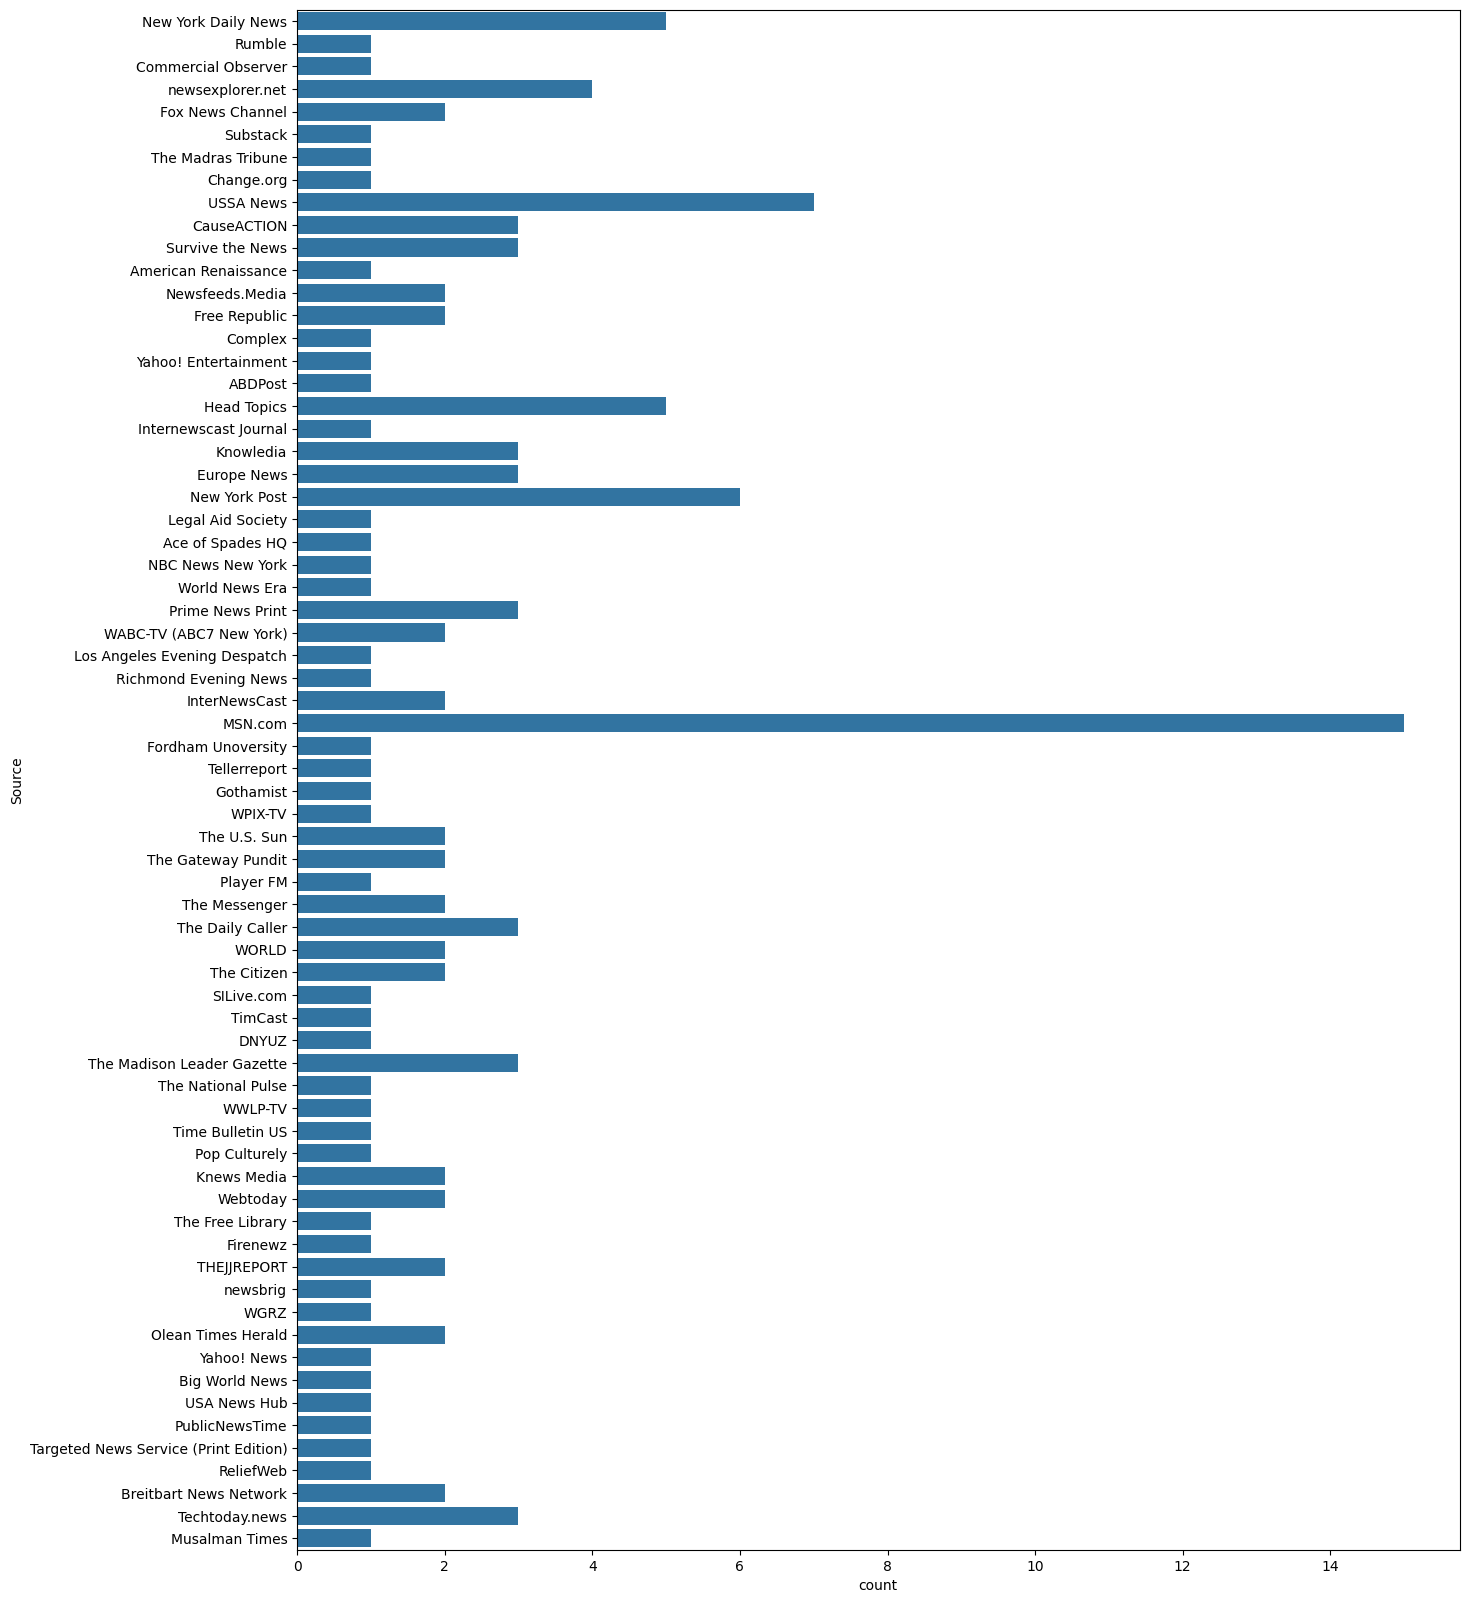

In [ ]:
# Plot 'Source' Distribution beforee Changing Classifications
fig, ax = plt.subplots(figsize=(15, 20))
sns.countplot(y='Source', data=newspapersClean)
plt.show()

In [9]:
# Assign Numeric Classifications
sources = newspapersClean['Source'].unique()
for i in range(len(sources)):
  newspapersClean.loc[newspapersClean['Source'] == sources[i], 'Source'] = i
originalSourceClassifications = newspapersClean['Source']  # Save classifications for ease of reading with clusters

# Binary Encoding for low values to avoid bad effect on clustering
binaryEncoder = ce.BinaryEncoder(cols=['Source'])
newspapersClean = binaryEncoder.fit_transform(newspapersClean)

newspapersClean.head()

,Source_0,Source_1,Source_2,Source_3,Source_4,Source_5,Source_6,Reach,Desktop Reach,Mobile Reach,Sentiment.1,Do they reference crime?,Do they reference laws?,Do they mention Housing?,Do they mention taxes/money?,Do they mention political affiliation?
0,0,0,0,0,0,0,1,5437834.0,1142877.0,4294957.0,2.0,1.0,2.0,1.0,1.0,2.0
1,0,0,0,0,0,1,0,32479287.0,5795432.0,26683855.0,2.0,2.0,2.0,2.0,2.0,2.0
2,0,0,0,0,0,1,1,247198.0,87311.0,159887.0,2.0,2.0,1.0,1.0,1.0,2.0
3,0,0,0,0,1,0,0,3762.0,3762.0,0.0,2.0,1.0,2.0,1.0,1.0,2.0
4,0,0,0,0,1,0,1,51520443.0,11211586.0,40308857.0,2.0,1.0,2.0,2.0,2.0,2.0


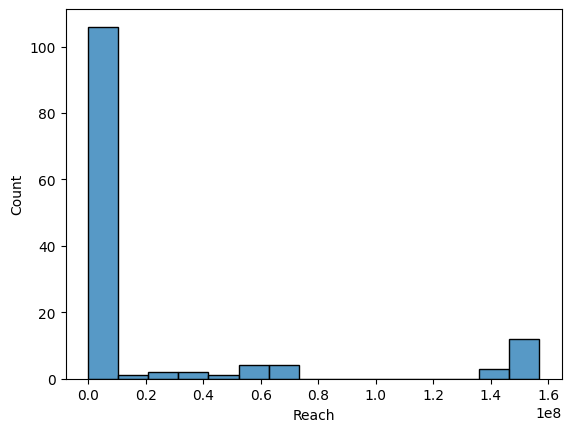

In [ ]:
# Plot 'Reach' Distriution
sns.histplot(newspapersClean['Reach'], bins=15)
plt.show()

Given the scale and distribution, we should standardize and normalize this variable. I am not removing the outliers that are most likely here since this distribution makes sense for a variable like this. You are natuarally going to have fewer accounts with more reach.

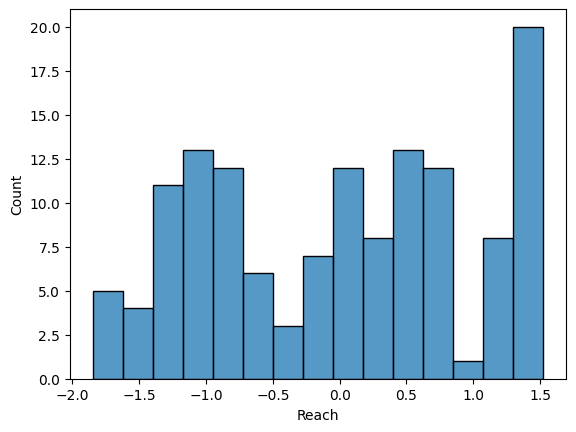

In [10]:
# Log transformation for skew
newspapersClean['Reach'] = np.log1p(newspapersClean['Reach'])

# Standardize 'Reach'
newspapersClean['Reach'] = (newspapersClean['Reach'] - newspapersClean['Reach'].mean()) / newspapersClean['Reach'].std()

sns.histplot(newspapersClean['Reach'], bins=15)
plt.show()

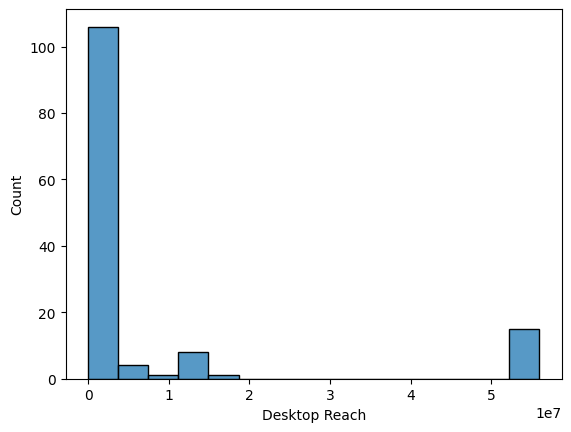

In [ ]:
# Plot 'Desktop Reach' Distriution
sns.histplot(newspapersClean['Desktop Reach'], bins=15)
plt.show()

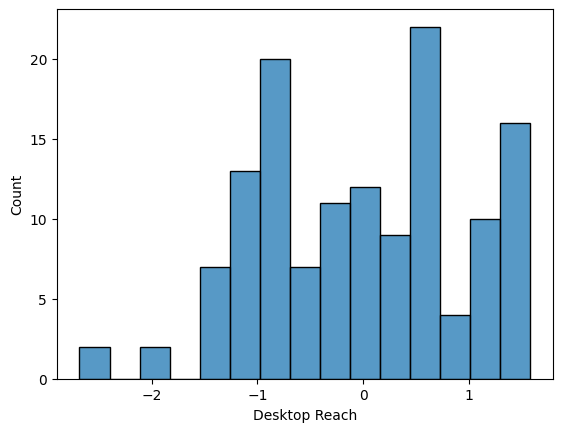

In [11]:
# Log transformation for skew
newspapersClean['Desktop Reach'] = np.log1p(newspapersClean['Desktop Reach'])

# Standardize 'Desktop Reach'
newspapersClean['Desktop Reach'] = (newspapersClean['Desktop Reach'] - newspapersClean['Desktop Reach'].mean()) / newspapersClean['Desktop Reach'].std()
sns.histplot(newspapersClean['Desktop Reach'], bins=15)
plt.show()

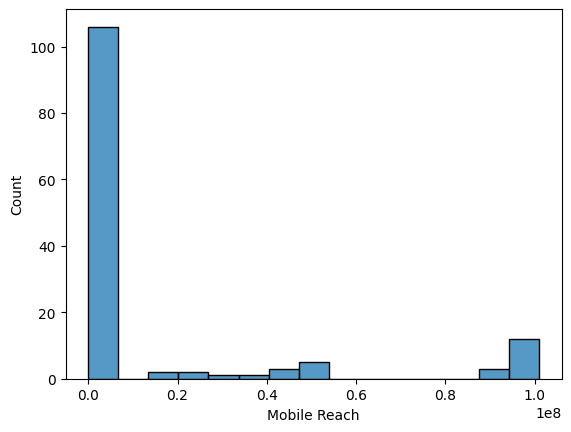

In [ ]:
# Plot 'Mobile Reach' Distriution
sns.histplot(newspapersClean['Mobile Reach'], bins=15)
plt.show()

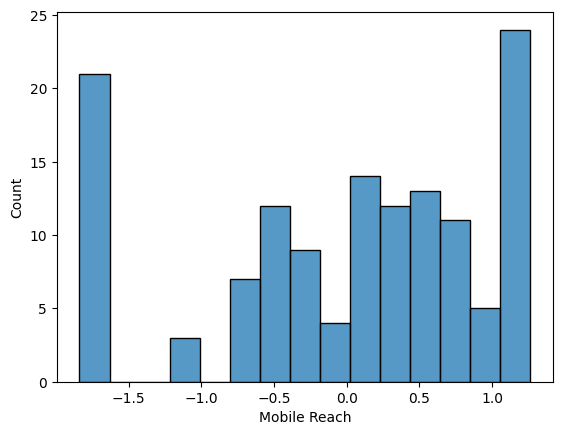

In [12]:
# Log transformation for skew
newspapersClean['Mobile Reach'] = np.log1p(newspapersClean['Mobile Reach'])

# Standardize 'Mobile Reach'
newspapersClean['Mobile Reach'] = (newspapersClean['Mobile Reach'] - newspapersClean['Mobile Reach'].mean()) / newspapersClean['Mobile Reach'].std()
sns.histplot(newspapersClean['Mobile Reach'], bins=15)
plt.show()

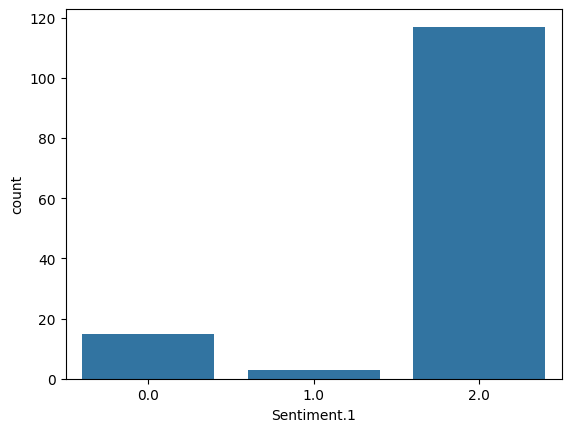

In [ ]:
# Plot 'Sentiment.1' Distriution
sns.countplot(x = 'Sentiment.1', data = newspapersClean)
plt.show()

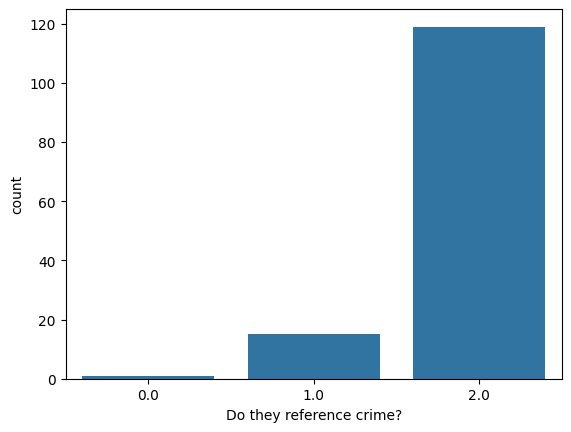

In [ ]:
# Plot 'Do they reference crime?' Distriution
sns.countplot(x = 'Do they reference crime?', data = newspapersClean)
plt.show()

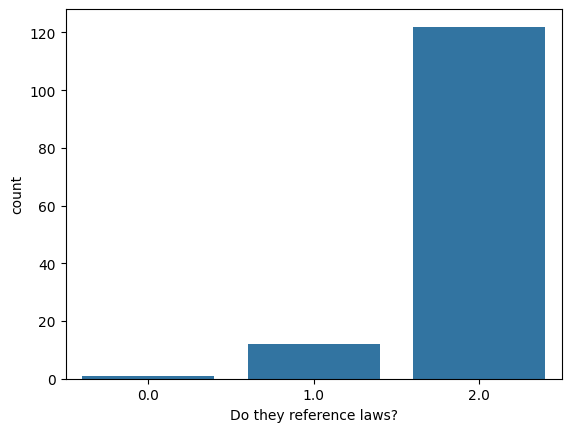

In [ ]:
# Plot 'Do they reference laws?' Distriution
sns.countplot(x = 'Do they reference laws?', data = newspapersClean)
plt.show()

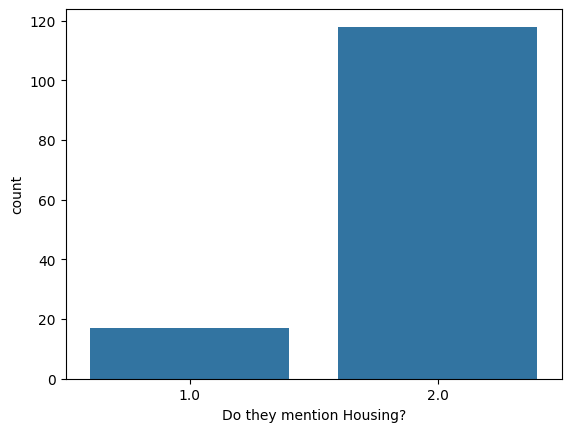

In [ ]:
# Plot 'Do they mention Housing?' Distriution
sns.countplot(x = 'Do they mention Housing?', data = newspapersClean)
plt.show()

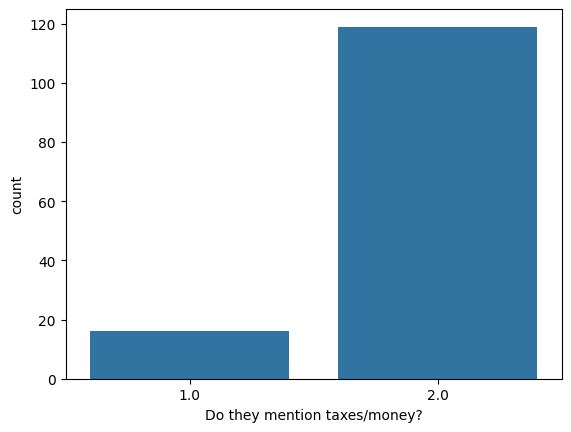

In [ ]:
# Plot 'Do they mention taxes/money?' Distriution
sns.countplot(x = 'Do they mention taxes/money?', data = newspapersClean)
plt.show()

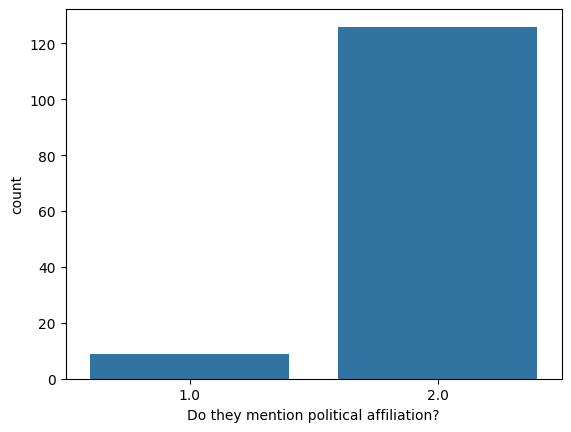

In [13]:
# Plot 'Do they mention political affiliation?' Distriution
newspapersClean.columns = newspapersClean.columns.str.strip()
sns.countplot(x = 'Do they mention political affiliation?', data = newspapersClean)
plt.show()

In [ ]:
newspapersClean.head()

,Source_0,Source_1,Source_2,Source_3,Source_4,Source_5,Source_6,Reach,Desktop Reach,Mobile Reach,Sentiment.1,Do they reference crime?,Do they reference laws?,Do they mention Housing?,Do they mention taxes/money?,Do they mention political affiliation?
0,0,0,0,0,0,0,1,-0.356052,-0.363261,-0.349485,2.0,1.0,2.0,1.0,1.0,2.0
1,0,0,0,0,0,1,0,0.194277,-0.094884,0.349272,2.0,2.0,2.0,2.0,2.0,2.0
2,0,0,0,0,0,1,1,-0.461689,-0.424150,-0.478541,2.0,2.0,1.0,1.0,1.0,2.0
3,0,0,0,0,1,0,0,-0.466643,-0.428970,-0.483531,2.0,1.0,2.0,1.0,1.0,2.0
4,0,0,0,0,1,0,1,0.581789,0.217541,0.774508,2.0,1.0,2.0,2.0,2.0,2.0


### Newspaper Corpus

In [14]:
# Combine text together
newspapersCorpusClean['text'] = newspapersCorpusClean['Headline'].fillna('') + ' ' + newspapersCorpusClean['Hit Sentence'].fillna('') + ' ' + newspapersCorpusClean['Key Phrases'].fillna('')

<ipython-input-14-e68ed45c7371>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newspapersCorpusClean['text'] = newspapersCorpusClean['Headline'].fillna('') + ' ' + newspapersCorpusClean['Hit Sentence'].fillna('') + ' ' + newspapersCorpusClean['Key Phrases'].fillna('')


In [15]:
# Method to process the text
def preprocessText(text):

    # Normalize text
    text = text.lower()  # Lowercase text
    text = re.sub(r'[^a-z\s]', '', text) # Remove special characters and digits

    # Tokenize the text
    words = text.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update('rt', 'qt', '...')
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

In [16]:
# Process Corpus
newspapersCorpusClean['processed_text'] = newspapersCorpusClean['text'].apply(preprocessText)
newspapersCorpusClean.head()

<ipython-input-16-d17d7b23400b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newspapersCorpusClean['processed_text'] = newspapersCorpusClean['text'].apply(preprocessText)


,Headline,Hit Sentence,Key Phrases,text,processed_text
0,Dozens of migrant men found crammed in Queens ...,"... about New York City budget, spending cuts ...","adams administration,affordable housing,baseme...",Dozens of migrant men found crammed in Queens ...,dozens migrant men found crammed queens furnit...
1,Anthony Agüero Live back in California,... seconds 15 seconds Another explosive after...,"explosive afternoon,migrants crisis",Anthony Agüero Live back in California ... sec...,anthony agero live back california seconds sec...
2,Migrants Crisis a Lifeline for New York City H...,... in the cost to shelter them. The city has ...,"adams administration,asylum seekers,budget,cit...",Migrants Crisis a Lifeline for New York City H...,migrants crisis lifeline new york city hotels ...
3,NYC Council moves to join lawsuit to force May...,... press conference hizzoner discussed recent...,"adams’ city hall counsel,city,city shelter pop...",NYC Council moves to join lawsuit to force May...,nyc council moves join lawsuit force mayor ada...
4,"The Big Weekend Show - Saturday, February 17","Civil fraud, Migrants crisis, Putin ...","civil fraud,migrants crisis","The Big Weekend Show - Saturday, February 17 C...",big weekend show saturday february civil fraud...


### Tweet Dataset

In [ ]:
tweetsClean.head()

,Reach,Twitter Followers,Twitter Following,Is Verified,Twitter Sender Category,News Sender Category,Sentiment.1,Do they reference crime?,Do they reference laws?,Do they mention Housing?,Do they mention taxes/money?,Do they mention political affiliation?
0,1871.0,1871.0,3362.0,True,1.0,Twitter,0.0,2.0,1.0,2.0,2.0,2.0
1,106.0,106.0,219.0,False,1.0,Twitter,0.0,2.0,2.0,2.0,2.0,1.0
2,2771.0,2771.0,3264.0,False,1.0,Twitter,0.0,2.0,1.0,2.0,2.0,2.0
3,3012.0,3012.0,3541.0,False,1.0,Twitter,0.0,2.0,2.0,2.0,2.0,2.0
4,15870.0,15870.0,15180.0,True,1.0,Twitter,2.0,2.0,2.0,2.0,2.0,2.0


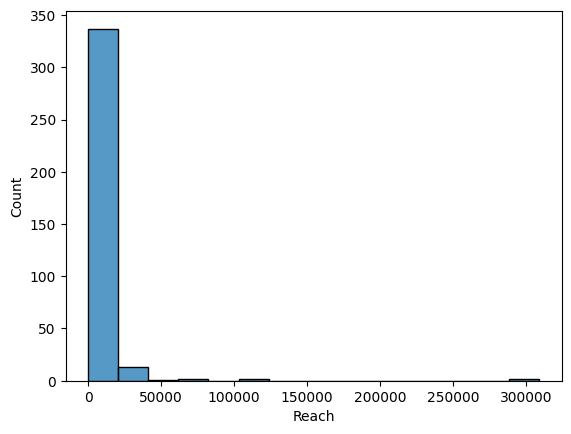

In [ ]:
# Plot 'Reach' Distriution
sns.histplot(tweetsClean['Reach'], bins=15)
plt.show()

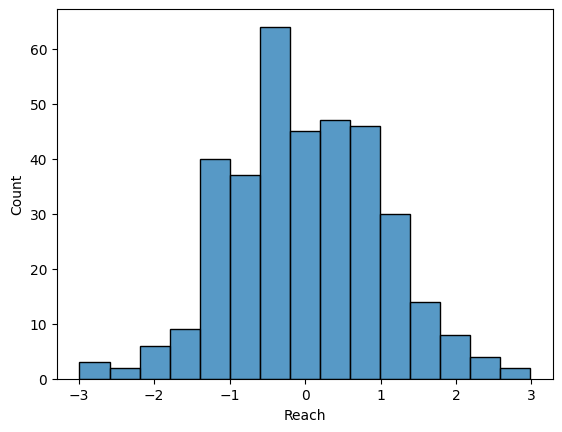

In [17]:
# Log transformation for skew
tweetsClean['Reach'] = np.log1p(tweetsClean['Reach'])

# Standardize 'Reach'
tweetsClean['Reach'] = (tweetsClean['Reach'] - tweetsClean['Reach'].mean()) / tweetsClean['Reach'].std()
sns.histplot(tweetsClean['Reach'], bins=15)
plt.show()

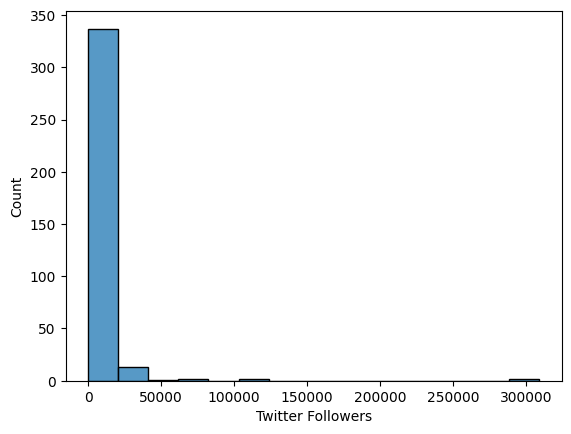

In [ ]:
# Plot 'Twitter Followers' Distriution
sns.histplot(tweetsClean['Twitter Followers'], bins=15)
plt.show()

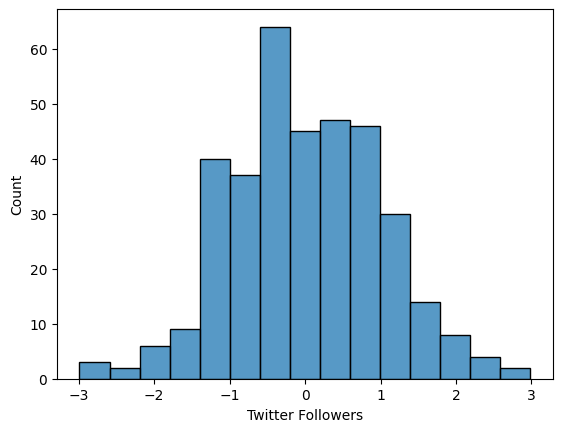

In [18]:
# Log transformation for skew
tweetsClean['Twitter Followers'] = np.log1p(tweetsClean['Twitter Followers'])

# Standardize 'Twitter Followers'
tweetsClean['Twitter Followers'] = (tweetsClean['Twitter Followers'] - tweetsClean['Twitter Followers'].mean()) / tweetsClean['Twitter Followers'].std()
sns.histplot(tweetsClean['Twitter Followers'], bins=15)
plt.show()

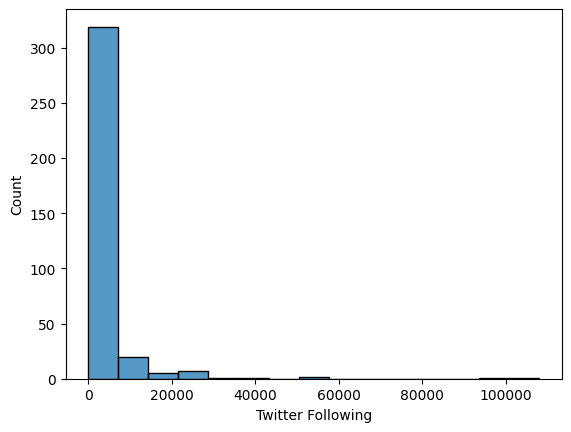

In [ ]:
# Plot 'Twitter Following' Distriution
sns.histplot(tweetsClean['Twitter Following'], bins=15)
plt.show()

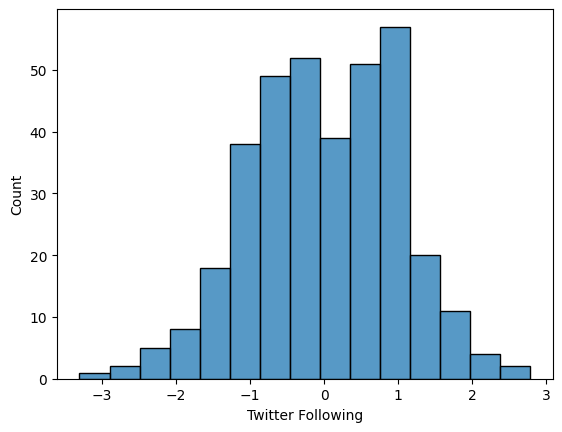

In [19]:
# Log transformation for skew
tweetsClean['Twitter Following'] = np.log1p(tweetsClean['Twitter Following'])

# Standardize 'Twitter Following'
tweetsClean['Twitter Following'] = (tweetsClean['Twitter Following'] - tweetsClean['Twitter Following'].mean()) / tweetsClean['Twitter Following'].std()
sns.histplot(tweetsClean['Twitter Following'], bins=15)
plt.show()

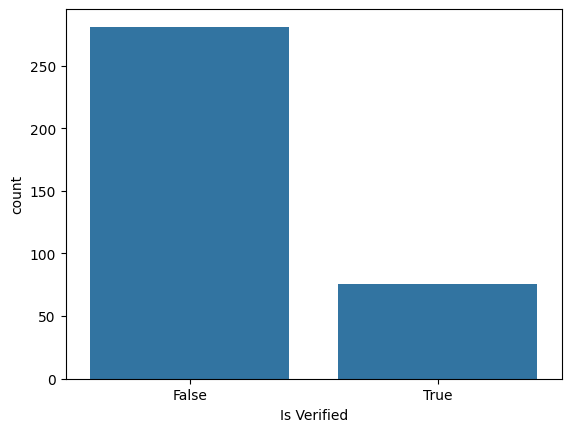

In [ ]:
# Plot 'Twitter Following' Distriution
sns.countplot(x = 'Is Verified', data=tweetsClean)
plt.show()

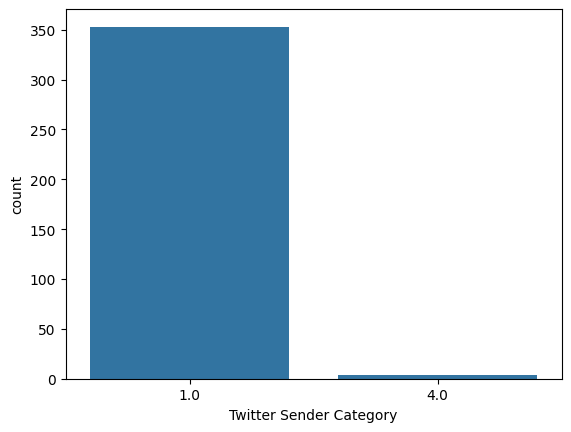

In [ ]:
# Plot 'Twitter Sender Category' Distriution
sns.countplot(x = 'Twitter Sender Category', data=tweetsClean)
plt.show()

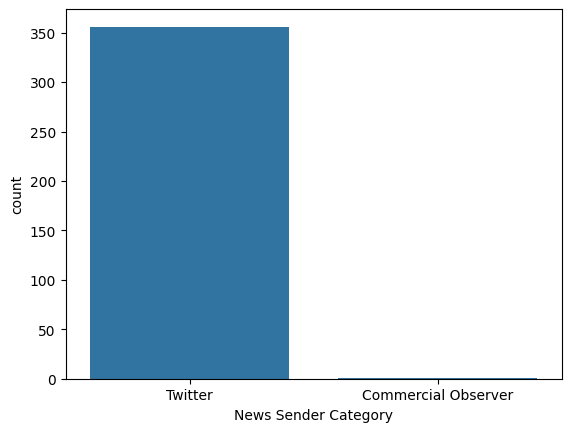

In [ ]:
# Plot 'News Sender Category' Distriution
sns.countplot(x = 'News Sender Category', data=tweetsClean)
plt.show()

In [20]:
# Drop 'News Sender Category'
tweetsClean = tweetsClean.drop(columns=['News Sender Category'])

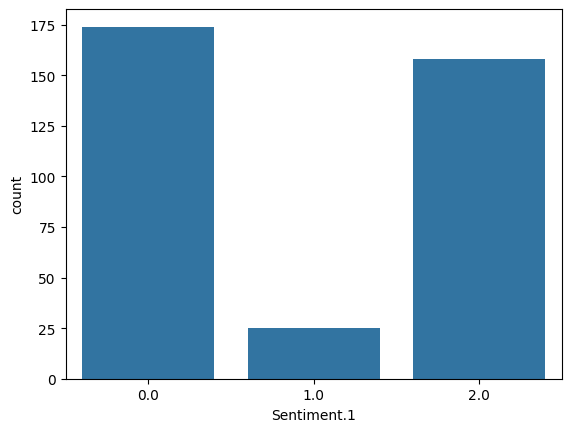

In [ ]:
# Plot 'Sentiment.1' Distriution
sns.countplot(x = 'Sentiment.1', data=tweetsClean)
plt.show()

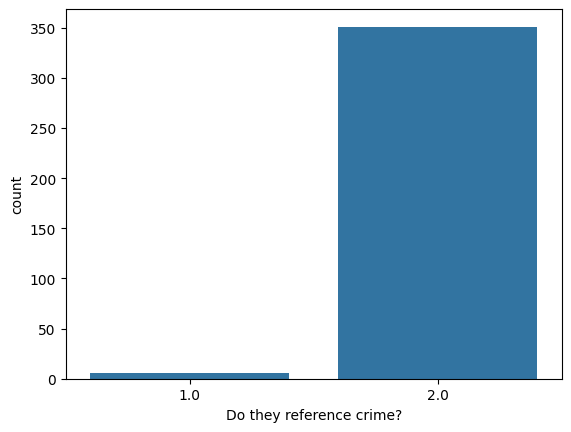

In [ ]:
# Plot 'Do they reference crime?' Distriution
sns.countplot(x = 'Do they reference crime?', data=tweetsClean)
plt.show()

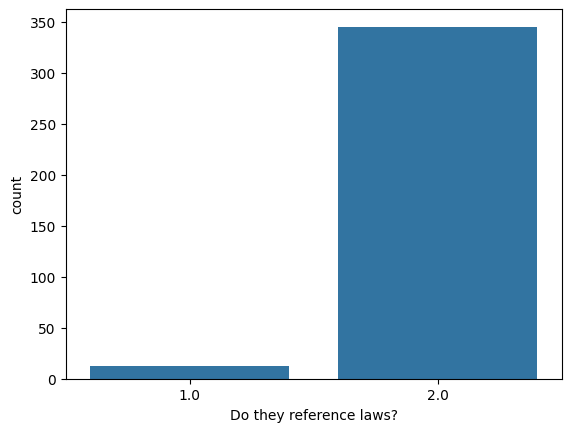

In [ ]:
# Plot 'Do they reference laws?' Distriution
sns.countplot(x = 'Do they reference laws?', data=tweetsClean)
plt.show()

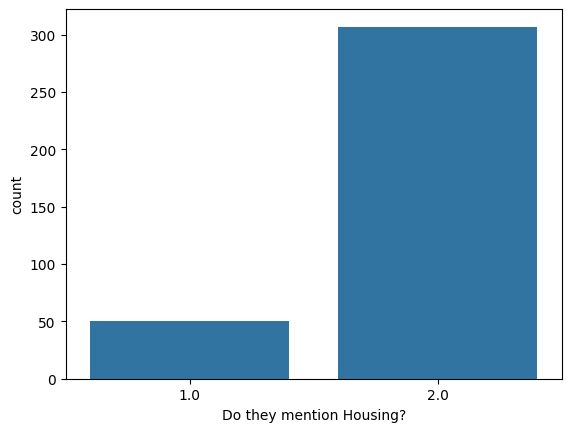

In [ ]:
# Plot 'Do they mention Housing?' Distriution
sns.countplot(x = 'Do they mention Housing?', data = tweetsClean)
plt.show()

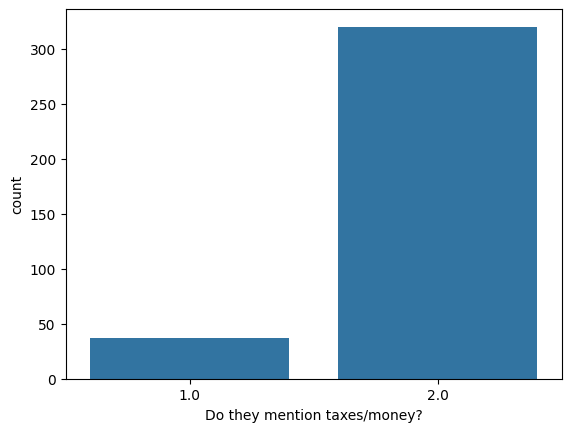

In [ ]:
# Plot 'Do they mention taxes/money?' Distriution
sns.countplot(x = 'Do they mention taxes/money?', data = tweetsClean)
plt.show()

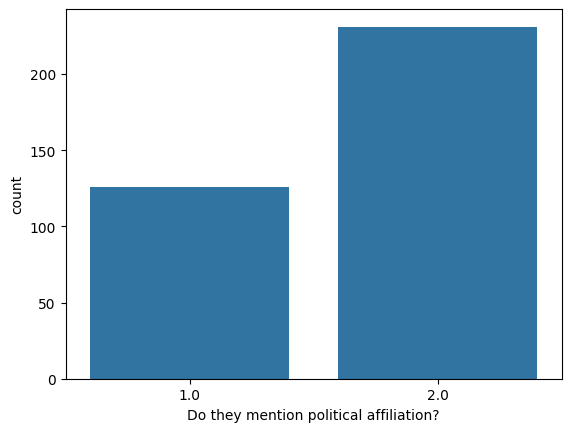

In [21]:
# Plot 'Do they mention political affiliation?' Distriution
tweetsClean.columns = tweetsClean.columns.str.strip()
sns.countplot(x = 'Do they mention political affiliation?', data = tweetsClean)
plt.show()

In [ ]:
tweetsClean.head()

,Reach,Twitter Followers,Twitter Following,Is Verified,Twitter Sender Category,Sentiment.1,Do they reference crime?,Do they reference laws?,Do they mention Housing?,Do they mention taxes/money?,Do they mention political affiliation?
0,0.431679,0.431679,0.668642,True,1.0,0.0,2.0,1.0,2.0,2.0,2.0
1,-0.999914,-0.999914,-0.993351,False,1.0,0.0,2.0,2.0,2.0,2.0,1.0
2,0.628046,0.628046,0.650618,False,1.0,0.0,2.0,1.0,2.0,2.0,2.0
3,0.669748,0.669748,0.700248,False,1.0,0.0,2.0,2.0,2.0,2.0,2.0
4,1.500890,1.500890,1.587237,True,1.0,2.0,2.0,2.0,2.0,2.0,2.0


### Tweet Corpus

In [22]:
# Combine text together
tweetsCorpusClean['text'] = tweetsCorpusClean['Hit Sentence'].fillna('') + ' ' + tweetsCorpusClean['Key Phrases'].fillna('')

<ipython-input-22-06808ebbe7f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweetsCorpusClean['text'] = tweetsCorpusClean['Hit Sentence'].fillna('') + ' ' + tweetsCorpusClean['Key Phrases'].fillna('')


In [23]:
# Process Corpus
tweetsCorpusClean['processed_text'] = tweetsCorpusClean['text'].apply(preprocessText)
tweetsCorpusClean.head()

<ipython-input-23-3ba889542272>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweetsCorpusClean['processed_text'] = tweetsCorpusClean['text'].apply(preprocessText)


,Hit Sentence,Key Phrases,text,processed_text
0,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,illegal migrants crisis,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,omg peter doocy roast karine jeanpierre illega...
1,@JoyceWhiteVance No matter how the liberals sp...,"boneheaded gift thereat,creature,matter,migran...",@JoyceWhiteVance No matter how the liberals sp...,joycewhitevance matter liberals spin migrants ...
2,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,"giant smog fart,illegal migrants crisis",OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,omg peter doocy roast karine jeanpierre illega...
3,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,illegal migrants crisis,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,omg peter doocy roast karine jeanpierre illega...
4,#Mayor #EricAdams Criticized for Past Statemen...,"illegals,past statements",#Mayor #EricAdams Criticized for Past Statemen...,mayor ericadams criticized past statements ill...


# Clustering

## Newspaper Dataset

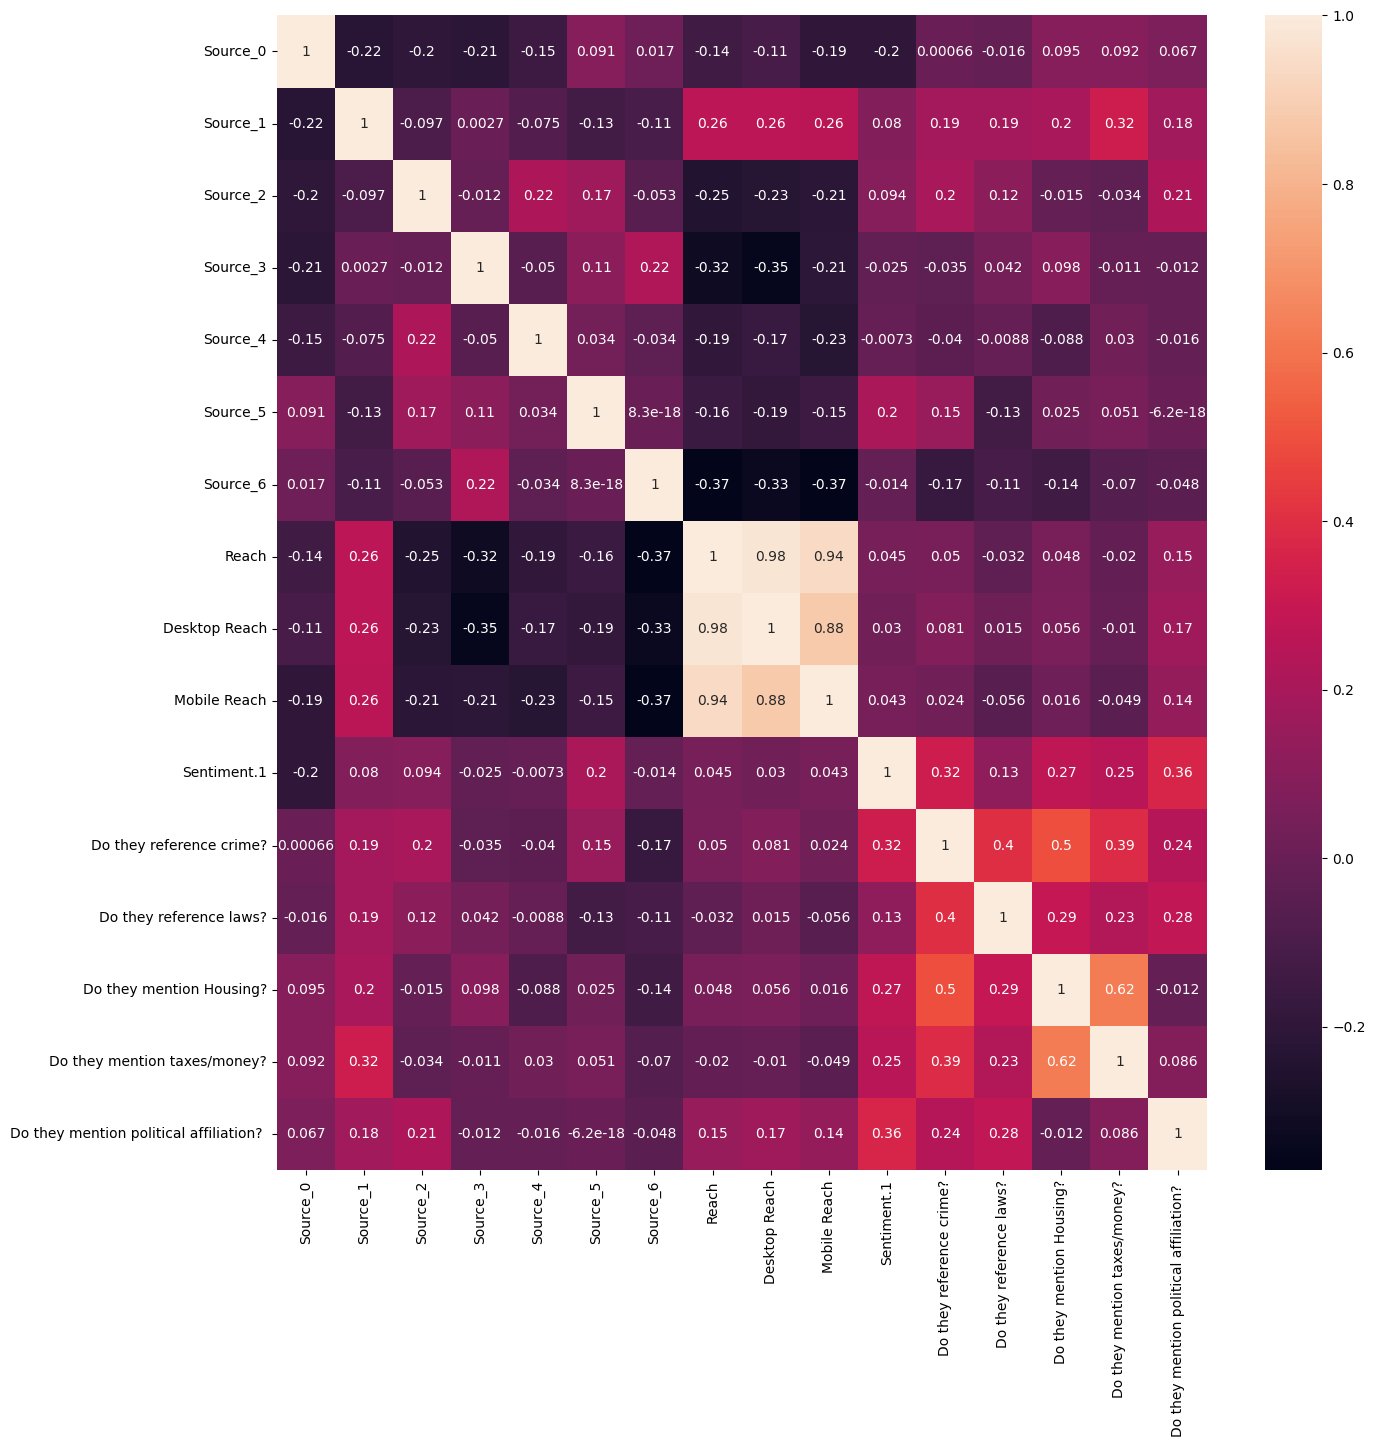

In [ ]:
# Heatmap for newspaper dataset
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(newspapersClean.corr(), annot=True)
plt.show()

Let's keep Reach and drop Desktop Reach and Mobile Reach

In [ ]:
# Drop 'Desktop Reach' and 'Mobile Reach'
newspapersClean = newspapersClean.drop(columns=['Desktop Reach', 'Mobile Reach'])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 17, cost: 792.0
Run 1, iteration: 2/100, moves: 22, cost: 789.0
Run 1, iteration: 3/100, moves: 14, cost: 789.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 19, cost: 777.0
Run 2, iteration: 2/100, moves: 13, cost: 775.0
Run 2, iteration: 3/100, moves: 0, cost: 775.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9, cost: 866.0
Run 3, iteration: 2/100, moves: 26, cost: 815.0
Run 3, iteration: 3/100, moves: 29, cost: 795.0
Run 3, iteration: 4/100, moves: 20, cost: 782.0
Run 3, iteration: 5/100, moves: 10, cost: 782.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 21, cost: 798.0
Run 4, iteration: 2/100, moves: 7, cost: 794.0
Run 4, iteration: 3/100, moves: 0, cost: 794.0
Init: initia

[]

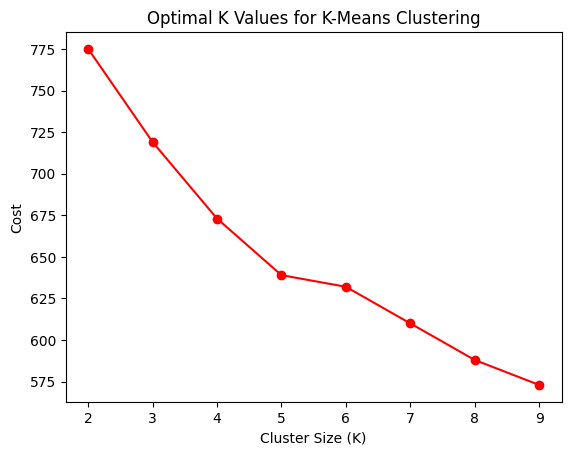

In [ ]:
# Run K-Modes Clustering on newspaper dataset, find best K

# Define & fit model, saving silhouette scores for Each K Value
kValues = {}
clusters = range(2, 10)
for k in clusters:
    kMode1 = KModes(n_clusters = k, init='random', n_init=5, verbose=1)
    clusters = kMode1.fit_predict(newspapersClean)
    kValues[k] = kMode1.cost_

# Plot
plt.plot(kValues.keys(), kValues.values(), color='red', marker = 'o')
plt.xlabel('Cluster Size (K)')
plt.ylabel('Cost')
plt.title('Optimal K Values for K-Means Clustering')
plt.plot()

In [75]:
# Run KModes w/ optimal K to get labels
kMode1 = KModes(n_clusters = 5, init='random', n_init=5, verbose=1)
clusters = kMode1.fit_predict(newspapersClean)
newspapersClean['Clusters'] = clusters
newspapersClean.head()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 31, cost: 588.0
Run 1, iteration: 2/100, moves: 24, cost: 578.0
Run 1, iteration: 3/100, moves: 7, cost: 578.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 37, cost: 603.0
Run 2, iteration: 2/100, moves: 5, cost: 603.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 20, cost: 599.0
Run 3, iteration: 2/100, moves: 13, cost: 599.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 44, cost: 617.0
Run 4, iteration: 2/100, moves: 6, cost: 617.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 37, cost: 582.0
Run 5, iteration: 2/100, moves: 23, cost: 581.0
Run 5, iteration: 3/100, moves: 0, cost: 581.0
Best run was number 1


,Source_0,Source_1,Source_2,Source_3,Source_4,Source_5,Source_6,Reach,Desktop Reach,Mobile Reach,Sentiment.1,Do they reference crime?,Do they reference laws?,Do they mention Housing?,Do they mention taxes/money?,Do they mention political affiliation?,Clusters
0,0,0,0,0,0,0,1,0.739838,0.649398,0.732094,2.0,1.0,2.0,1.0,1.0,2.0,3
1,0,0,0,0,0,1,0,1.157424,1.036968,1.039498,2.0,2.0,2.0,2.0,2.0,2.0,0
2,0,0,0,0,0,1,1,0.017635,0.035448,0.178294,2.0,2.0,1.0,1.0,1.0,2.0,0
3,0,0,0,0,1,0,0,-0.960190,-0.715159,-1.838212,2.0,1.0,2.0,1.0,1.0,2.0,3
4,0,0,0,0,1,0,1,1.265225,1.194495,1.108920,2.0,1.0,2.0,2.0,2.0,2.0,1


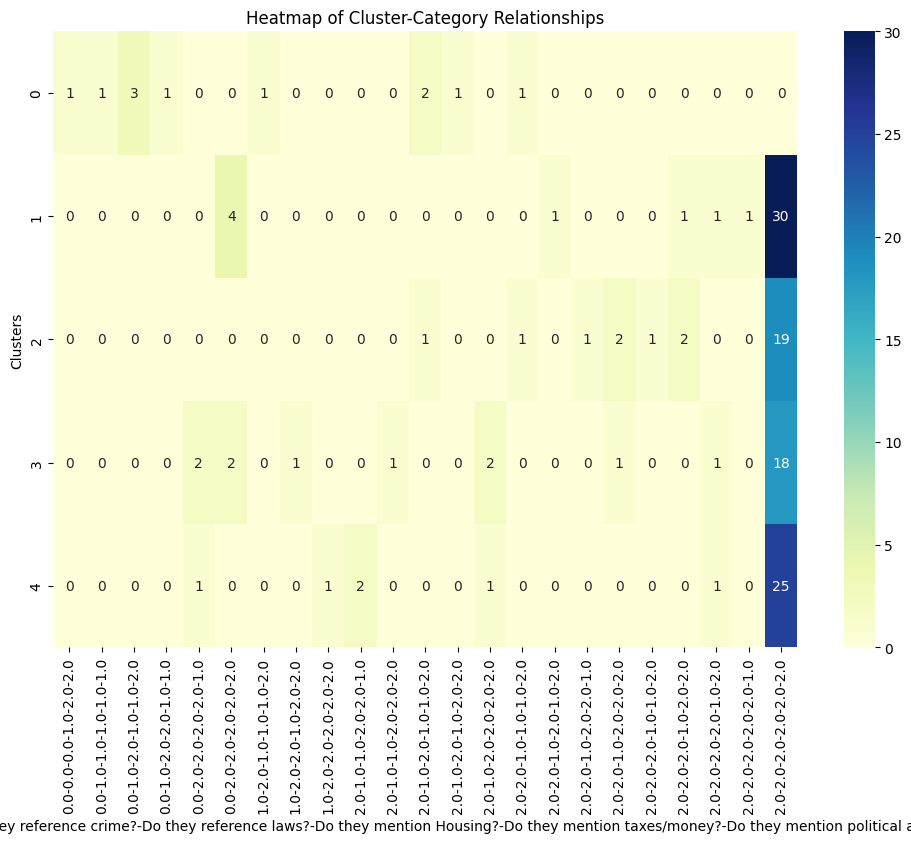

In [ ]:
# Create a contingency table
contingencyTable = pd.crosstab(newspapersClean['Clusters'], [newspapersClean['Sentiment.1'], newspapersClean['Do they reference crime?'], newspapersClean['Do they reference laws?'],
                                                             newspapersClean['Do they mention Housing?'], newspapersClean['Do they mention taxes/money?'],
                                                             newspapersClean['Do they mention political affiliation?']])

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contingencyTable, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap of Cluster-Category Relationships')
plt.show()

In [ ]:
newspapersClean.columns

Index(['Source_0', 'Source_1', 'Source_2', 'Source_3', 'Source_4', 'Source_5',
       'Source_6', 'Reach', 'Desktop Reach', 'Mobile Reach', 'Sentiment.1',
       'Do they reference crime?', 'Do they reference laws?',
       'Do they mention Housing?', 'Do they mention taxes/money?',
       'Do they mention political affiliation?', 'Clusters'],
      dtype='object')

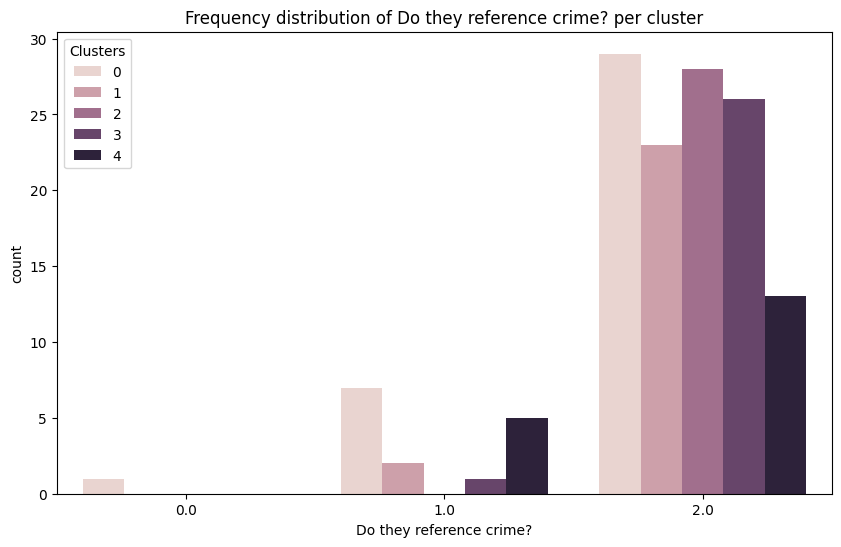

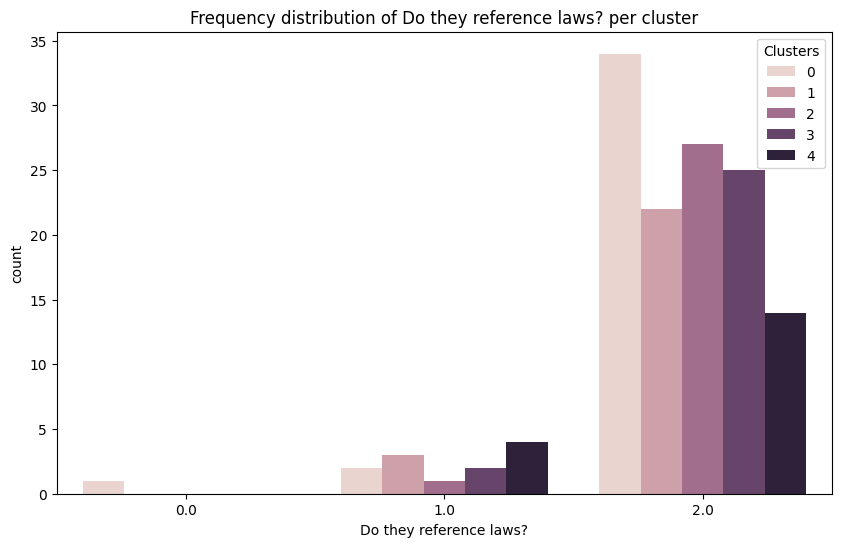

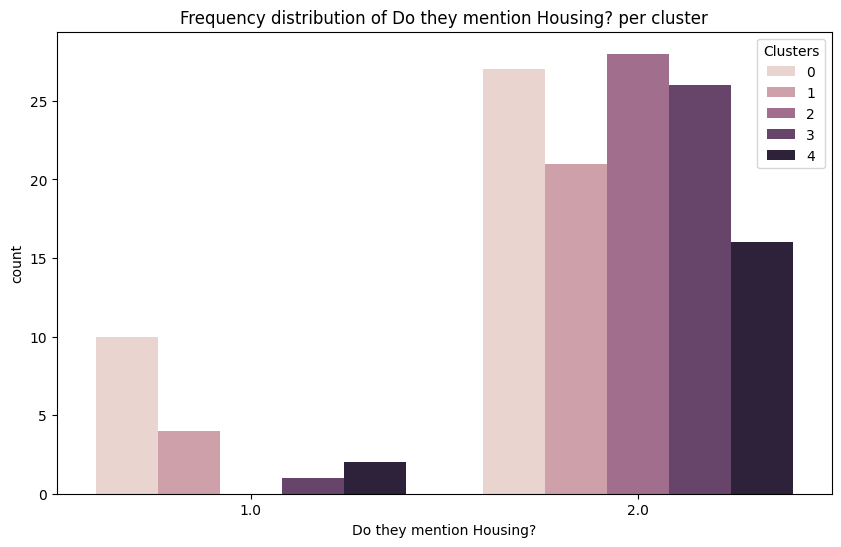

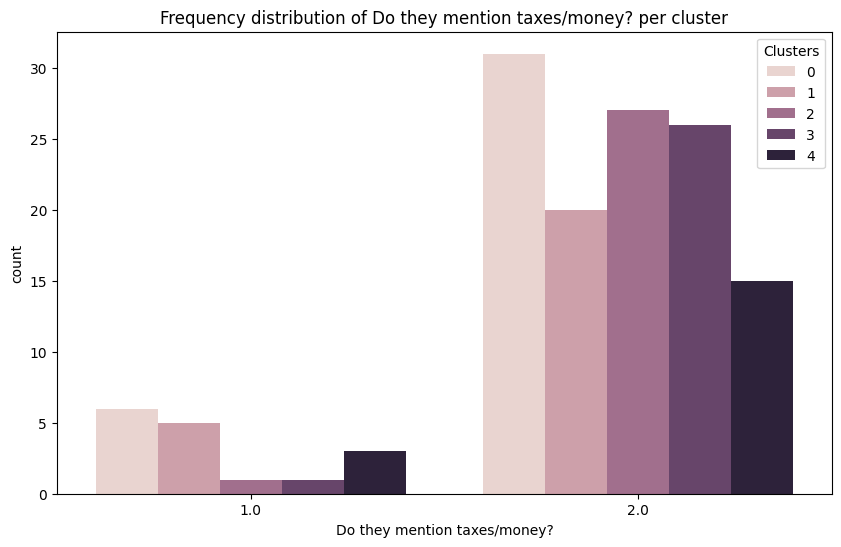

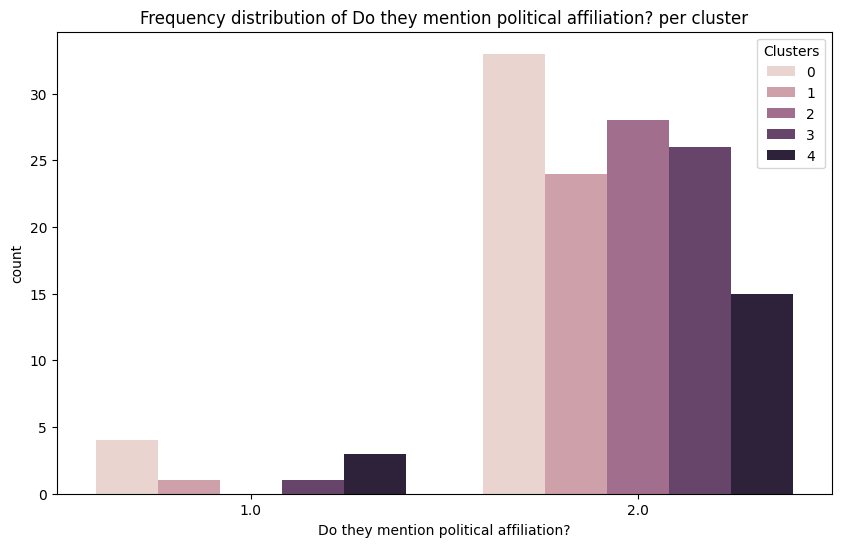

In [ ]:
# Display frequency distribution of each category per cluster
for column in newspapersClean.columns[11:-1]:  # Exclude the 'Cluster' column
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue='Clusters', data=newspapersClean)
    plt.title(f'Frequency distribution of {column} per cluster')
    plt.show()

In [ ]:
# Plot Clusters
fig = px.scatter_3d(newspapersClean, x='Reach', y='Desktop Reach', z='Mobile Reach', color='Clusters')
fig.update_layout(title_text = 'Original Dataset KMeans Results (K = 5)')
fig.show()

In [76]:
silhouette_score(newspapersClean, newspapersClean['Clusters'])

0.2033968600730796

## Clustering Headlines Directly

In [ ]:
newspapersCorpusClean.head()

,Headline,Hit Sentence,Key Phrases,text,processed_text
0,Dozens of migrant men found crammed in Queens ...,"... about New York City budget, spending cuts ...","adams administration,affordable housing,baseme...",Dozens of migrant men found crammed in Queens ...,dozens migrant men found crammed queens furnit...
1,Anthony Agüero Live back in California,... seconds 15 seconds Another explosive after...,"explosive afternoon,migrants crisis",Anthony Agüero Live back in California ... sec...,anthony agero live back california seconds sec...
2,Migrants Crisis a Lifeline for New York City H...,... in the cost to shelter them. The city has ...,"adams administration,asylum seekers,budget,cit...",Migrants Crisis a Lifeline for New York City H...,migrants crisis lifeline new york city hotels ...
3,NYC Council moves to join lawsuit to force May...,... press conference hizzoner discussed recent...,"adams’ city hall counsel,city,city shelter pop...",NYC Council moves to join lawsuit to force May...,nyc council moves join lawsuit force mayor ada...
4,"The Big Weekend Show - Saturday, February 17","Civil fraud, Migrants crisis, Putin ...","civil fraud,migrants crisis","The Big Weekend Show - Saturday, February 17 C...",big weekend show saturday february civil fraud...


In [85]:
# Word Embeddings w/ Word2Vec
# This is done to vectorize the words in a meaningful way to be able to cluster them
tokens = [text.split() for text in newspapersCorpusClean['processed_text']]

# Train Word2Vec
model = Word2Vec(tokens, vector_size=100, window=5, min_count=1, workers=4)

# Get word vectors into dataframe
wordVectors = model.wv
words = wordVectors.index_to_key
vectors = [wordVectors[word] for word in words]
headlinesVectorized = pd.DataFrame(vectors, index=words)
headlinesVectorized.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
migrants,-0.003524,0.004305,0.005508,0.010683,-0.009159,-0.014346,0.007227,0.017924,-0.007842,-0.005106,...,0.004450,0.002350,0.004934,-0.000145,0.016290,0.010169,-0.005784,-0.010726,0.001797,0.007515
crisis,-0.011549,0.007617,0.005606,0.007303,0.007805,-0.013260,0.002110,0.014351,-0.005743,-0.007874,...,0.004301,0.000475,0.003944,-0.008287,0.003711,0.007703,0.007857,-0.006206,-0.009242,0.004946
new,-0.001654,0.004954,-0.006522,-0.000881,0.007966,0.003740,-0.003229,0.007294,-0.010102,0.005456,...,-0.003113,0.007106,0.009901,-0.004262,0.011550,0.008653,0.007419,-0.001647,0.008773,-0.006543
adams,-0.009923,0.011212,-0.000189,-0.001251,0.004835,-0.007704,0.003406,0.012134,0.004624,-0.008043,...,-0.006192,0.000267,-0.000195,-0.002675,0.013516,0.001852,0.007600,-0.009517,-0.001898,-0.005202
border,-0.009246,0.003992,-0.006982,-0.000797,0.004163,0.000794,0.001957,0.008324,-0.006518,0.006065,...,0.004980,-0.003367,0.006473,-0.003917,0.007124,-0.004738,0.008242,0.002704,0.001744,0.003921


[]

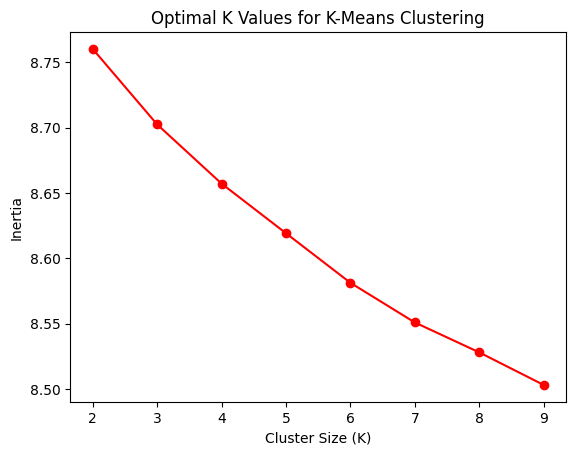

In [ ]:
# Run K-Means Clustering on tweets dataset, find best K

# Define & fit model, saving silhouette scores for Each K Value
kValues = {}
clusters = range(2, 10)
for k in clusters:
    kMeans2 = KMeans(n_clusters = k, random_state=0, n_init='auto').fit(vectors)
    kMeansOriginalLabels = kMeans2.predict(vectors)
    kValues[k] = kMeans2.inertia_

# Plot
plt.plot(kValues.keys(), kValues.values(), color='red', marker = 'o')
plt.xlabel('Cluster Size (K)')
plt.ylabel('Inertia')
plt.title('Optimal K Values for K-Means Clustering')
plt.plot()

In [86]:
# Run KMeans w/ optimal K to get labels
kMeansHeadlines = KMeans(n_clusters = 3, random_state=0, n_init='auto').fit(vectors)
kMeansHeadlinesLabels = kMeansHeadlines.predict(vectors)

# PCA to plot
pca = PCA(n_components=3)
reducedVectors = pca.fit_transform(vectors)

# Create a DataFrame for the reduced vectors
headlinesVectorizedReduced = pd.DataFrame(reducedVectors, columns=['PC1', 'PC2', 'PC3'])
headlinesVectorizedReduced['Word'] = words
headlinesVectorizedReduced['Clusters'] = kMeansHeadlinesLabels

# Plot the clusters
fig = px.scatter_3d(headlinesVectorizedReduced, x='PC1', y='PC2', z='PC3', color='Clusters')
fig.update_layout(title_text = 'Headlines KMeans Results (K = 3)')
fig.show()
'''
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Clusters', data=headlinesVectorizedReduced, palette='viridis', legend='full')

for i in range(headlinesVectorizedReduced.shape[0]):
    plt.text(headlinesVectorizedReduced.PC1[i], headlinesVectorizedReduced.PC2[i], headlinesVectorizedReduced.Word[i], fontsize=9)

plt.title('Word Clusters')
plt.show()
'''

"\nplt.figure(figsize=(12, 8))\nsns.scatterplot(x='PC1', y='PC2', hue='Clusters', data=headlinesVectorizedReduced, palette='viridis', legend='full')\n\nfor i in range(headlinesVectorizedReduced.shape[0]):\n    plt.text(headlinesVectorizedReduced.PC1[i], headlinesVectorizedReduced.PC2[i], headlinesVectorizedReduced.Word[i], fontsize=9)\n\nplt.title('Word Clusters')\nplt.show()\n"

In [137]:
# Silhouette score for K=3
silhouette_score(headlinesVectorizedReduced[['PC1', 'PC2', 'PC3', 'Clusters']], headlinesVectorizedReduced['Clusters'])

0.7855316688645824

Our elbow plot tells us that we don't have to be too picky with our K size since there is no clear elbow point. Using K=3 allows us to generalize a little bit and this seems to give us decently defined clusters with a silhouette score of about .79

In [93]:
# Summarize the words in a cluster into one topic name
def getClusterTopic(words):

  # Get the words into one string for ChatGPT to process easily
  wordCollection = ""
  for word in words:
    wordCollection += " " + word

  # Get the topic
  request = openai.chat.completions.create(model = "gpt-3.5-turbo",
                                          messages = [{'role': 'user',
                                                      'content': f'All of the words are dervived from headlines/tweets regarding the US migrant crisis. Summarize these words into one topic name, be specific: {wordCollection}'}])

  return request.choices[0].message.content



In [228]:
# Sample records from each cluster
headlinesVectorizedReduced[headlinesVectorizedReduced['Clusters'] == 0].sample(10)

,PC1,PC2,PC3,Word,Clusters
1232,-0.106532,-0.042848,0.022325,making,0
2778,-0.721103,0.043485,0.007134,bordercountriesmigrants,0
2373,-0.398047,0.014603,-0.029723,title,0
3389,-0.623967,0.029178,-0.022279,warzone,0
3141,-0.427768,0.026201,0.005390,crisisprograms,0
1739,-0.349190,0.022277,0.011425,shelters,0
2211,-0.386901,0.016785,0.024318,affordable,0
4349,-0.740616,0.032010,-0.023870,matthewnichol,0
3097,-0.529887,0.016886,0.004120,bloke,0
4451,-0.620834,0.006802,-0.000007,advicedoorsmigrantsnyc,0


In [94]:
# Get cluster topic
clusterWords = headlinesVectorizedReduced[headlinesVectorizedReduced['Clusters'] == 0]
getClusterTopic(clusterWords['Word'])

'US Migrant Crisis with New York City Demands for Action'

Cluster 0 has words like "outrageous", "economics", and "bordercountriesmigrants", which may indicate headlines about the domestic political climate surrounding migrants.

In [243]:
headlinesVectorizedReduced[headlinesVectorizedReduced['Clusters'] == 1].sample(10)

,PC1,PC2,PC3,Word,Clusters
97,3.825402,-3.108281,-1.766473,homeless,1
246,1.707382,-0.631721,0.305159,feel,1
416,1.138998,0.118835,-0.100951,upon,1
571,3.375936,-0.169496,0.184440,trump,1
757,1.391121,-0.113013,0.043196,ny,1
655,1.217512,-0.455957,-0.089681,schools,1
462,1.622639,0.684704,0.168727,china,1
744,1.075334,-0.055281,0.112534,crisismoney,1
510,1.197005,-0.203842,1.112796,slowly,1
509,2.064895,-0.940593,1.044652,abundance,1


In [95]:
# Get cluster topic
clusterWords = headlinesVectorizedReduced[headlinesVectorizedReduced['Clusters'] == 1]
getClusterTopic(clusterWords['Word'])

'US Migrant Crisis amid Gov Policies and Shelter Shortage.'

Cluster 1 has words like "asylum", "degraded", "refugees", and "homeless", which possibly indicates headlines talking about the migrant population and how they are being treated/percieved here.

In [251]:
headlinesVectorizedReduced[headlinesVectorizedReduced['Clusters'] == 2].sample(10)

,PC1,PC2,PC3,Word,Clusters
215,2.708408,0.521582,-1.337447,antisemitism,2
126,3.304943,1.782891,1.102492,sanctuary,2
94,4.215496,3.539521,-1.280375,already,2
95,2.583695,0.445153,-0.448090,putting,2
7,4.250311,3.723499,-2.057417,netanyahu,2
21,5.164261,0.214690,-3.914401,destroy,2
584,1.651918,1.409935,-0.612907,anyone,2
73,4.067067,3.129867,-2.714179,fight,2
566,1.440073,1.052676,0.024925,put,2
283,1.853502,1.257000,-0.192157,rather,2


In [96]:
# Get cluster topic
clusterWords = headlinesVectorizedReduced[headlinesVectorizedReduced['Clusters'] == 2]
getClusterTopic(clusterWords['Word'])

'US Migrant Crisis and Refugee Assistance Programs'

Cluster 2 has words like "government", "budget", "geopolitical", "need", and "sanctuary", which probably indicated headlines that talk about government approach towards migrants, domestically and geopolitically

## Tweet Dataset

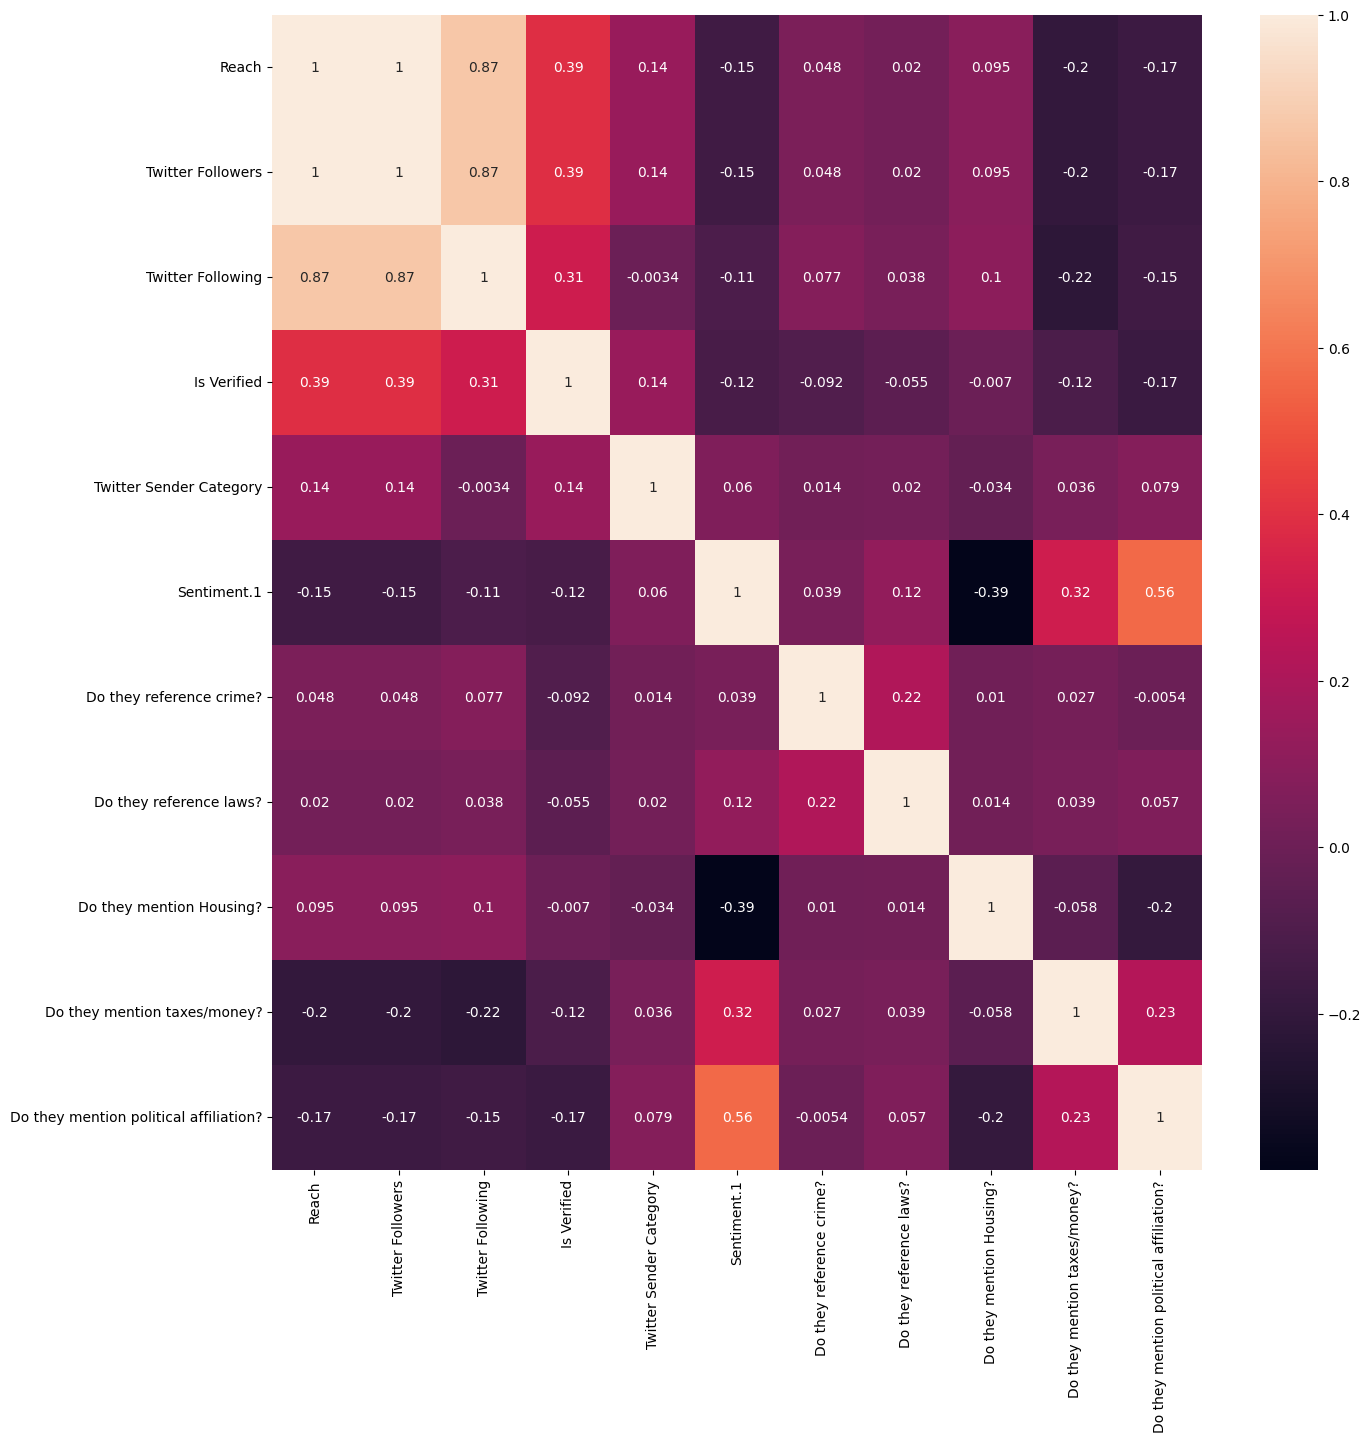

In [ ]:
# Heatmap for tweets dataset
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(tweetsClean.corr(), annot=True)
plt.show()

[]

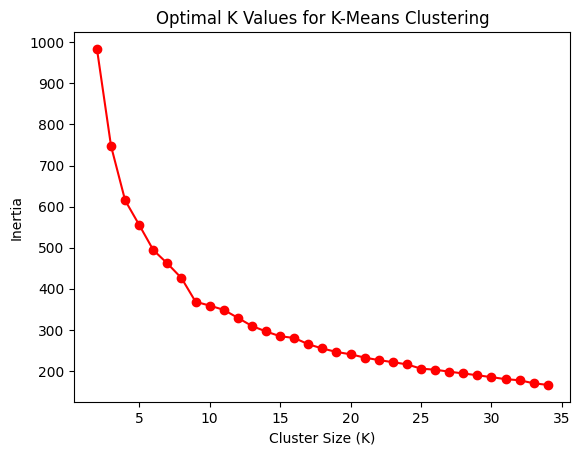

In [ ]:
# Run K-Means Clustering on tweets dataset, find best K

# Define & fit model, saving silhouette scores for Each K Value
kValues = {}
clusters = range(2, 35)
for k in clusters:
    kMeans2 = KMeans(n_clusters = k, random_state=0, n_init='auto').fit(tweetsClean)
    kMeansOriginalLabels = kMeans2.predict(tweetsClean)
    kValues[k] = kMeans2.inertia_

# Plot
plt.plot(kValues.keys(), kValues.values(), color='red', marker = 'o')
plt.xlabel('Cluster Size (K)')
plt.ylabel('Inertia')
plt.title('Optimal K Values for K-Means Clustering')
plt.plot()

In [ ]:
# Run KMeans w/ optimal K to get labels
kMeansTweets = KMeans(n_clusters = 9, random_state=0, n_init='auto').fit(tweetsClean)
kMeansTweetsLabels = kMeansTweets.predict(tweetsClean)
tweetsClean['Clusters'] = kMeansTweetsLabels
tweetsClean.head()

,Reach,Twitter Followers,Twitter Following,Is Verified,Twitter Sender Category,Sentiment.1,Do they reference crime?,Do they reference laws?,Do they mention Housing?,Do they mention taxes/money?,Do they mention political affiliation?,Clusters
0,0.431679,0.431679,0.668642,True,1.0,0.0,2.0,1.0,2.0,2.0,2.0,1
1,-0.999914,-0.999914,-0.993351,False,1.0,0.0,2.0,2.0,2.0,2.0,1.0,2
2,0.628046,0.628046,0.650618,False,1.0,0.0,2.0,1.0,2.0,2.0,2.0,1
3,0.669748,0.669748,0.700248,False,1.0,0.0,2.0,2.0,2.0,2.0,2.0,1
4,1.500890,1.500890,1.587237,True,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3


In [ ]:
# Silhouette score for K=9
silhouette_score(tweetsClean, tweetsClean['Clusters'])

0.5620534835137987

In [ ]:
# Plot Clusters
fig = px.scatter_3d(tweetsClean, x='Twitter Followers', y='Twitter Following', z='Reach', color='Clusters')
fig.update_layout(title_text = 'Tweets Dataset KMeans Results (K = 9)')
fig.show()

Due to the nature of our dataset here being way more categorical than continuous, it would be good to use KModes here instead of KMeans. Overall, interpreting these clusters with such few continuous variables is a challenge within itself.

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 77, cost: 1334.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 60, cost: 1334.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 1515.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 79, cost: 1336.0
Run 4, iteration: 2/100, moves: 19, cost: 1336.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 19, cost: 1332.0
Best run was number 5
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 34, cost: 1281.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 1264.0
Init: initializing centroids

[]

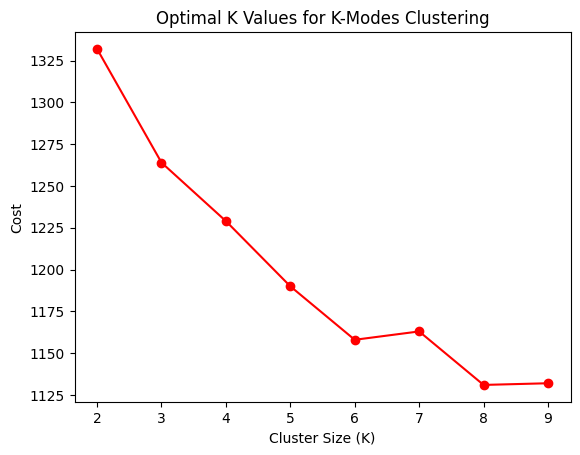

In [ ]:
# Use KModes instead to look at clustering

# Define & fit model, saving cost scores for Each K Value
kValues = {}
clusters = range(2, 10)
for k in clusters:
    kMode1 = KModes(n_clusters = k, init='random', n_init=5, verbose=1)
    clusters = kMode1.fit_predict(tweetsClean)
    kValues[k] = kMode1.cost_

# Plot
plt.plot(kValues.keys(), kValues.values(), color='red', marker = 'o')
plt.xlabel('Cluster Size (K)')
plt.ylabel('Cost')
plt.title('Optimal K Values for K-Modes Clustering')
plt.plot()

In [77]:
# Run KModes w/ optimal K to get labels
kMode1 = KModes(n_clusters = 6, init='random', n_init=5, verbose=1)
clusters = kMode1.fit_predict(tweetsClean)
tweetsClean['Clusters'] = clusters
tweetsClean.head()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 30, cost: 1233.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 1207.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 33, cost: 1187.0
Run 3, iteration: 2/100, moves: 4, cost: 1187.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 61, cost: 1189.0
Run 4, iteration: 2/100, moves: 0, cost: 1189.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 50, cost: 1250.0
Run 5, iteration: 2/100, moves: 1, cost: 1250.0
Best run was number 3


,Reach,Twitter Followers,Twitter Following,Is Verified,Twitter Sender Category,Sentiment.1,Do they reference crime?,Do they reference laws?,Do they mention Housing?,Do they mention taxes/money?,Do they mention political affiliation?,Clusters
0,0.431679,0.431679,0.668642,True,1.0,0.0,2.0,1.0,2.0,2.0,2.0,3
1,-0.999914,-0.999914,-0.993351,False,1.0,0.0,2.0,2.0,2.0,2.0,1.0,2
2,0.628046,0.628046,0.650618,False,1.0,0.0,2.0,1.0,2.0,2.0,2.0,5
3,0.669748,0.669748,0.700248,False,1.0,0.0,2.0,2.0,2.0,2.0,2.0,5
4,1.500890,1.500890,1.587237,True,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3


In [78]:
silhouette_score(tweetsClean, tweetsClean['Clusters'])

0.20556328861974799

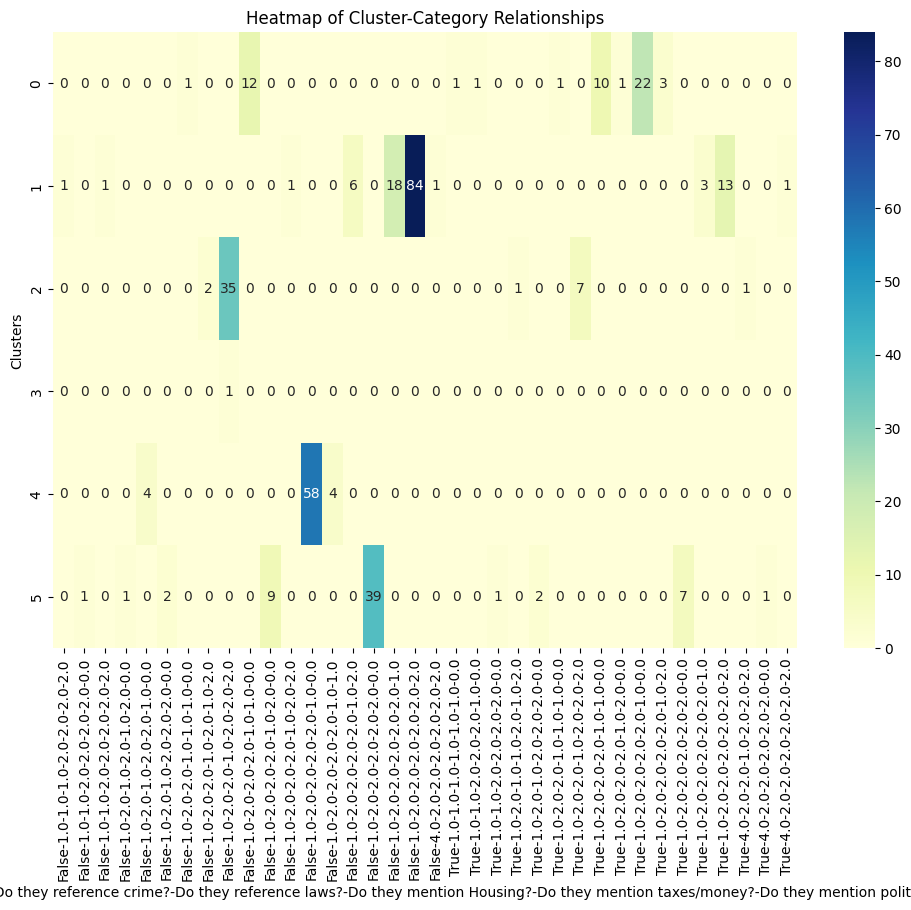

In [ ]:
# Create a contingency table
contingencyTable = pd.crosstab(tweetsClean['Clusters'], [tweetsClean['Is Verified'], tweetsClean['Twitter Sender Category'], tweetsClean['Do they reference crime?'],
                                                         tweetsClean['Do they reference laws?'], tweetsClean['Do they mention Housing?'],
                                                         tweetsClean['Do they mention taxes/money?'], tweetsClean['Do they mention political affiliation?'],
                                                         tweetsClean['Sentiment.1']])

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(contingencyTable, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap of Cluster-Category Relationships')
plt.show()

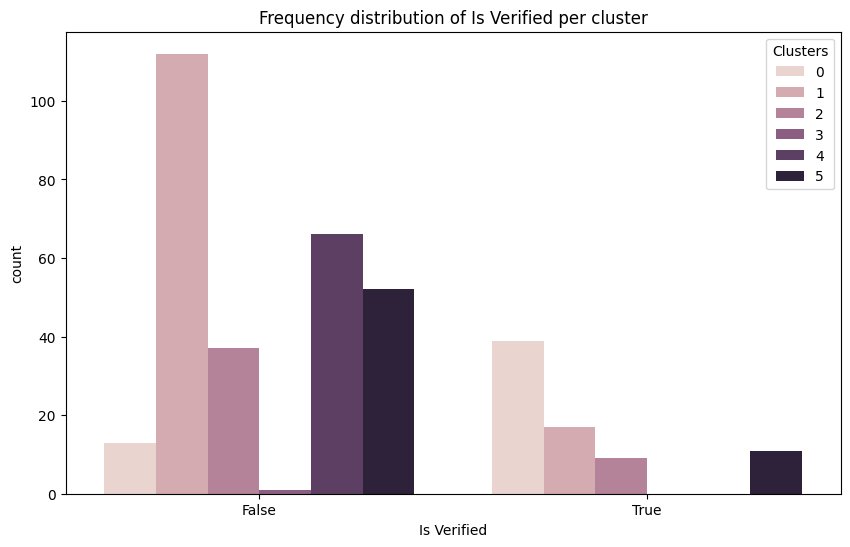

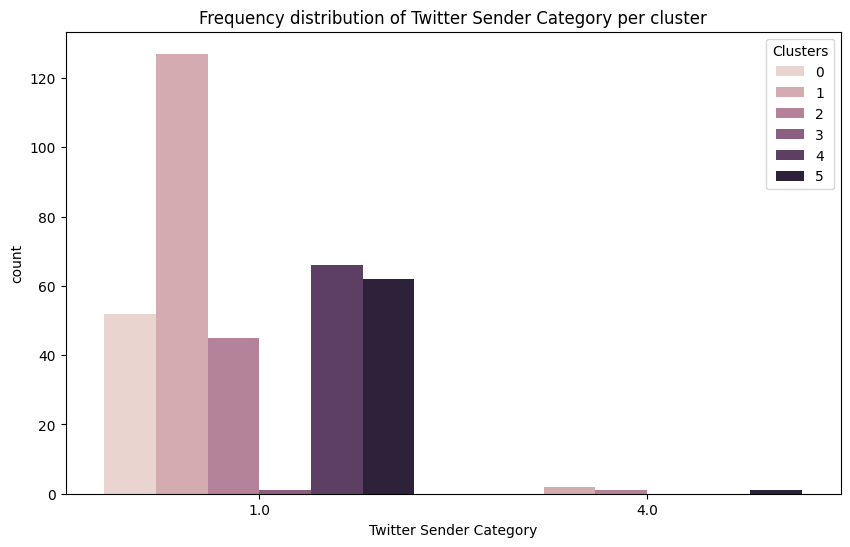

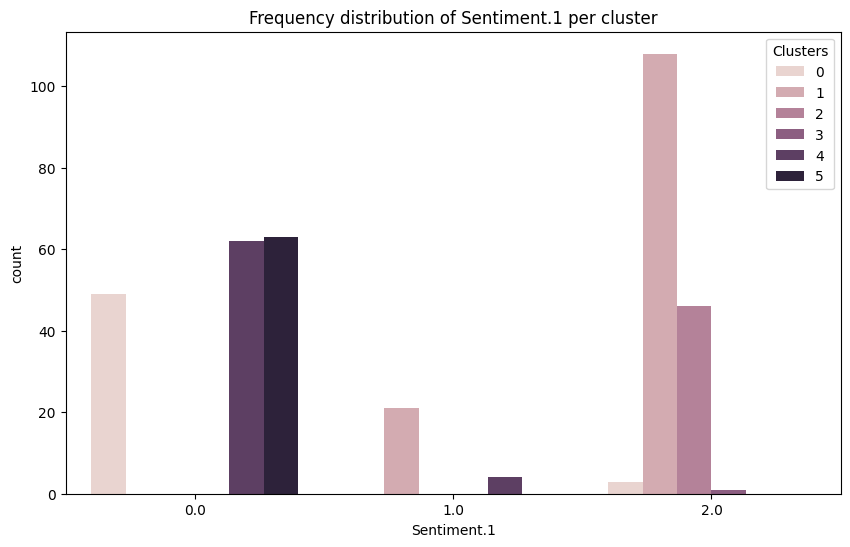

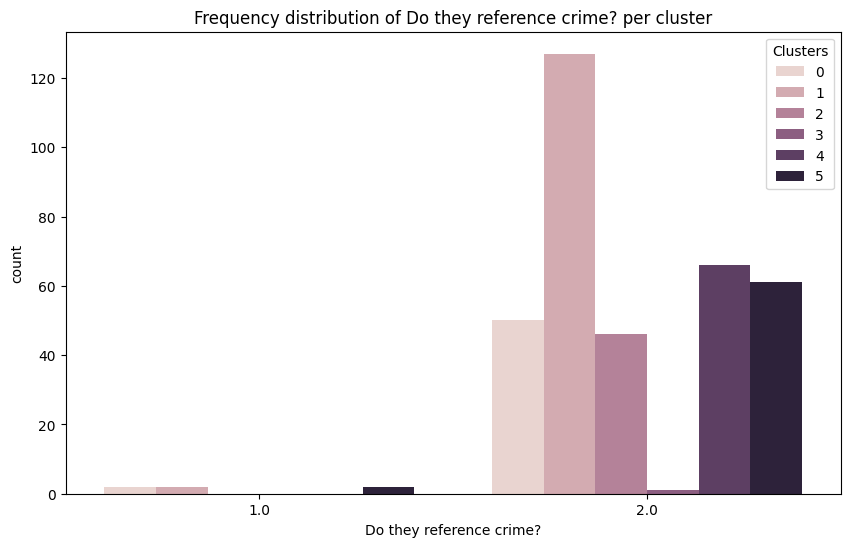

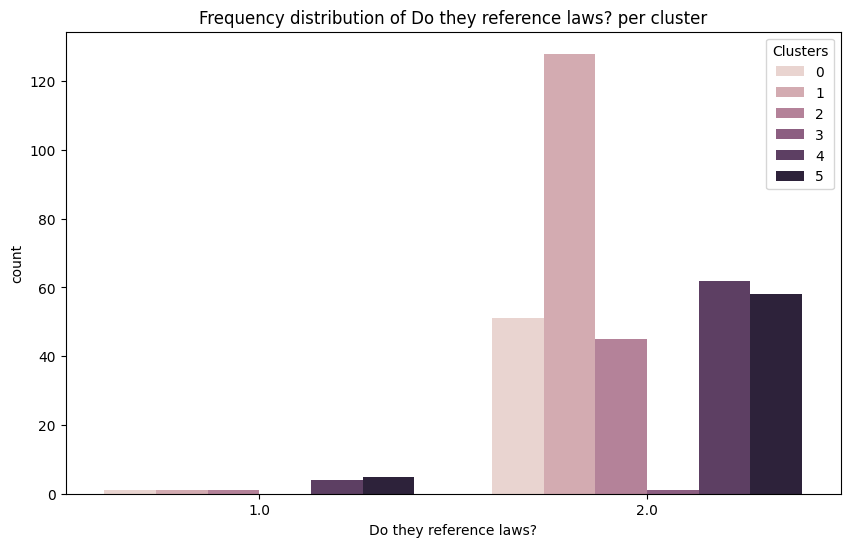

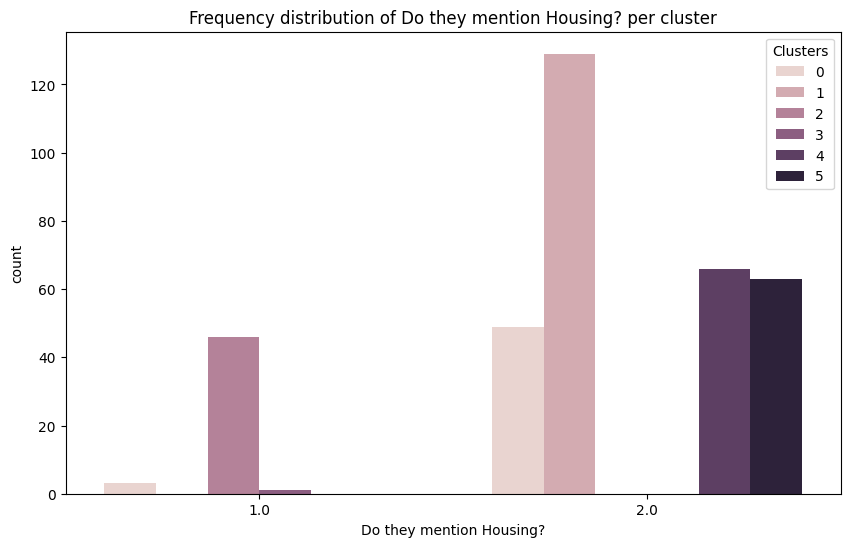

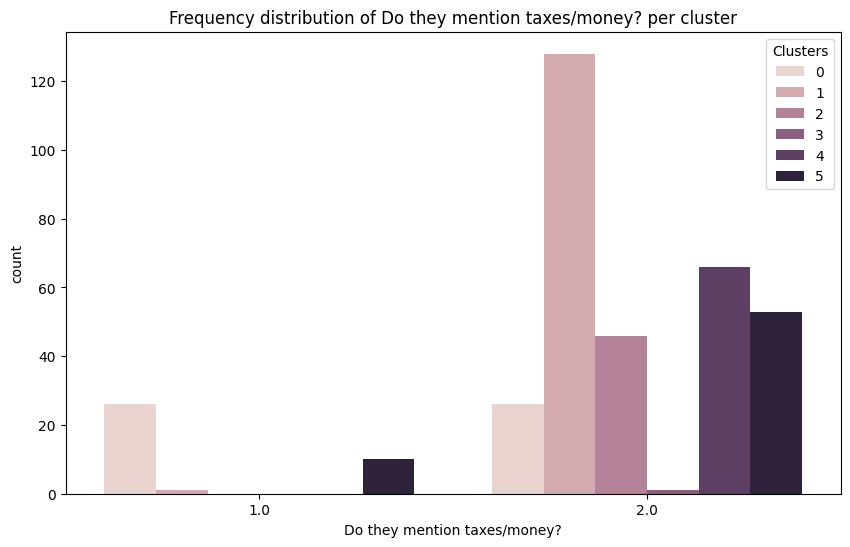

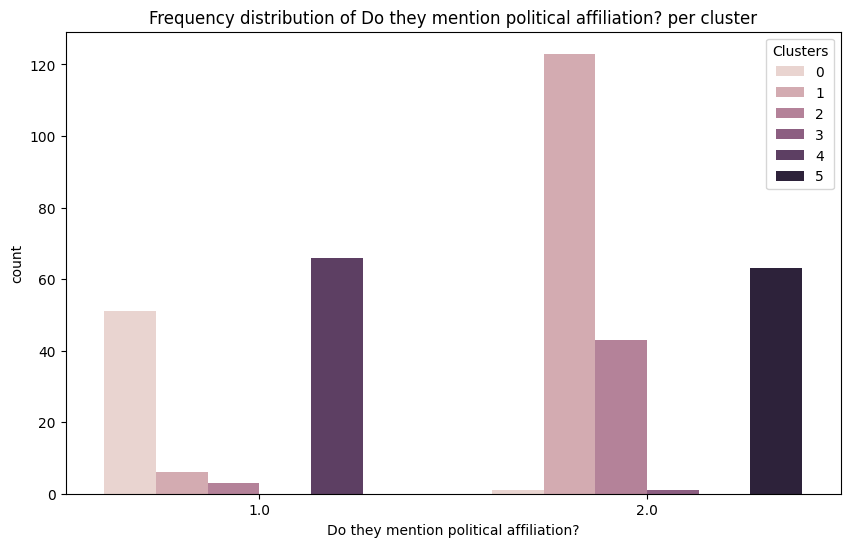

In [ ]:
# Display frequency distribution of each category per cluster
for column in tweetsClean.columns[3:-1]:  # Exclude the 'Cluster' column
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, hue='Clusters', data=tweetsClean)
    plt.title(f'Frequency distribution of {column} per cluster')
    plt.show()

## Clustering Tweets Directly

In [ ]:
tweetsCorpusClean.head()

,Hit Sentence,Key Phrases,text,processed_text
0,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,illegal migrants crisis,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,omg peter doocy roast karine jeanpierre illega...
1,@JoyceWhiteVance No matter how the liberals sp...,"boneheaded gift thereat,creature,matter,migran...",@JoyceWhiteVance No matter how the liberals sp...,joycewhitevance matter liberals spin migrants ...
2,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,"giant smog fart,illegal migrants crisis",OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,omg peter doocy roast karine jeanpierre illega...
3,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,illegal migrants crisis,OMG!! Peter Doocy ROAST Karine Jean-Pierre ove...,omg peter doocy roast karine jeanpierre illega...
4,#Mayor #EricAdams Criticized for Past Statemen...,"illegals,past statements",#Mayor #EricAdams Criticized for Past Statemen...,mayor ericadams criticized past statements ill...


In [97]:
# Word Embeddings w/ Word2Vec
tokens = [text.split() for text in tweetsCorpusClean['processed_text']]

# Train Word2Vec
model = Word2Vec(tokens, vector_size=100, window=5, min_count=1, workers=4)

# Get word vectors into dataframe
wordVectors = model.wv
words = wordVectors.index_to_key
vectors = [wordVectors[word] for word in words]
tweetsVectorized = pd.DataFrame(vectors, index=words)
tweetsVectorized.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
crisis,-0.005242,0.380646,-0.776307,-1.258309,0.805069,-1.409737,0.616145,1.249510,0.662644,-0.395173,...,-0.028732,0.244264,0.845821,-0.113780,0.866780,-0.382835,0.635877,-0.772278,-1.042943,-0.815230
migrants,-0.075949,0.412922,-0.419275,-1.269427,0.576050,-1.373809,0.456330,0.918148,0.881012,-0.342438,...,0.120589,0.139166,0.455347,0.134080,0.339525,-0.294712,0.161245,-0.733371,-1.186484,-0.415757
us,0.155710,-0.226837,-0.470281,-1.141974,0.574104,-1.191487,0.426338,-0.104884,0.304945,0.247192,...,0.490997,-0.546250,0.633295,0.764890,1.038134,0.721896,-0.206750,0.047047,-0.567229,-0.396585
rt,0.035385,0.286700,-0.168829,-1.320844,0.589422,-0.938322,0.159424,0.940011,0.974738,-0.719987,...,-0.044687,-0.021713,0.468775,0.227093,0.345683,-0.260100,0.103686,0.188362,-0.767391,-0.743585
city,-0.362353,1.103693,-1.266892,-1.199899,1.884299,-0.797523,-0.107406,1.261657,0.707519,0.283919,...,-0.122962,-0.019981,1.076930,-0.024493,1.217528,-1.141205,1.329773,-0.437574,-0.675493,-0.591614


[]

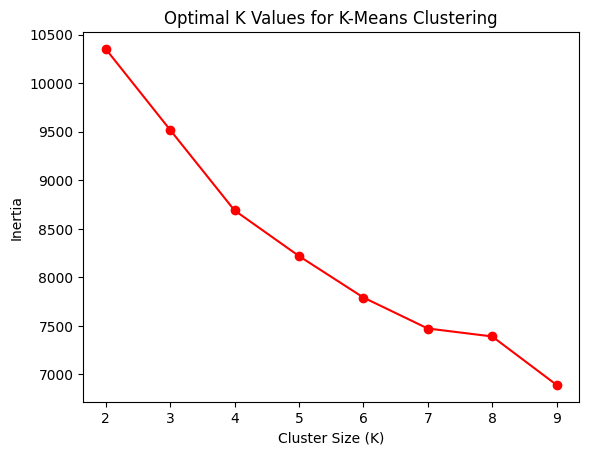

In [28]:
# Run K-Means Clustering on tweets dataset, find best K

# Define & fit model, saving silhouette scores for Each K Value
kValues = {}
clusters = range(2, 10)
for k in clusters:
    kMeans2 = KMeans(n_clusters = k, random_state=0, n_init='auto').fit(vectors)
    kMeansOriginalLabels = kMeans2.predict(vectors)
    kValues[k] = kMeans2.inertia_

# Plot
plt.plot(kValues.keys(), kValues.values(), color='red', marker = 'o')
plt.xlabel('Cluster Size (K)')
plt.ylabel('Inertia')
plt.title('Optimal K Values for K-Means Clustering')
plt.plot()

In [122]:
# Run KMeans w/ optimal K to get labels
kMeansTweets = KMeans(n_clusters = 7, random_state=0, n_init='auto').fit(vectors)
kMeansTweetsLabels = kMeansTweets.predict(vectors)

# PCA to plot
pca = PCA(n_components=3)
reducedVectors = pca.fit_transform(vectors)

# Create a DataFrame for the reduced vectors
tweetsVectorizedReduced = pd.DataFrame(reducedVectors, columns=['PC1', 'PC2', 'PC3'])
tweetsVectorizedReduced['Word'] = words
tweetsVectorizedReduced['Clusters'] = kMeansTweetsLabels

# Plot the clusters
fig = px.scatter_3d(tweetsVectorizedReduced, x='PC1', y='PC2', z='PC3', color='Clusters')
fig.update_layout(title_text = 'Tweets KMeans Results (K = 7)')
fig.show()

In [159]:
# Sample records from clusters
tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 0].sample(10)

,PC1,PC2,PC3,Word,Clusters
4427,-0.366068,0.038695,0.006777,spiraleconomyhealth,0
2623,-0.582218,0.011064,-0.014569,somewhere,0
2167,-0.312759,0.009664,0.032139,uses,0
2697,-0.568653,0.017721,-0.009164,migrantsillegal,0
3511,-0.671819,-0.002152,-0.005034,crisiswing,0
3370,-0.506566,0.023161,-0.001741,worsening,0
857,-0.110041,0.187265,0.071310,guess,0
3521,-0.557607,0.012844,-0.004610,mminnym,0
2432,-0.469256,0.000185,-0.007422,inhumane,0
1222,0.082390,-0.022692,-0.021897,nations,0


In [99]:
# Get cluster topic
clusterWords = tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 0]
getClusterTopic(clusterWords['Word'])

'US Migrant Crisis'

Cluster 0 has some text possibly relating to the treatment/perception of migrants, having words like "inhumane", "transit", "illness", and "threat" in the mix.

In [164]:
tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 1].sample(10)

,PC1,PC2,PC3,Word,Clusters
494,1.587977,-0.979176,-0.730635,massively,1
458,1.584319,0.214740,-0.976636,nowhere,1
381,1.535834,-0.492798,-0.423666,army,1
425,1.373903,0.040453,-1.692334,percentage,1
184,3.447611,0.734318,-2.338127,genocide,1
394,1.525205,-0.723395,1.281388,strait,1
262,2.171139,-1.749563,-0.137226,harder,1
533,1.812320,-1.056051,-0.843528,humiliate,1
354,1.590631,-0.995892,-0.396549,level,1
365,1.466049,-0.893876,-0.090113,strategic,1


In [100]:
# Get cluster topic
clusterWords = tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 1]
getClusterTopic(clusterWords['Word'])

'Migrant Crisis on US-Mexico Border'

In Cluster 1 words like  "nazi", "camp", and "holocaust" frequently come up, possbily making up a smaller group of people who feel strongly about the treatment of migrants as they come in. This can be supported by words in the cluster such as "suffering", "cold", and "abandonment"

In [165]:
tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 2].sample(10)

,PC1,PC2,PC3,Word,Clusters
137,2.516978,1.365400,0.830570,damescorpio,2
16,4.822674,3.124747,0.409931,war,2
160,3.330033,1.928328,-0.279328,th,2
34,3.390249,2.934400,-1.546722,million,2
88,3.860064,3.169110,-1.433041,way,2
41,5.094721,3.271816,0.480294,one,2
33,4.629412,2.239669,-3.181390,government,2
109,5.307831,1.652292,-2.479480,civilians,2
135,3.260169,2.038184,0.051054,months,2
176,3.263829,2.804753,-0.621550,supporting,2


In [101]:
# Get cluster topic
clusterWords = tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 2]
getClusterTopic(clusterWords['Word'])

'US Migrant Crisis and Urban Support'

Cluster 2 has words like "support", "sanctuary", "civilians", "war", and "govenment", possibly indicating that this is a cluster that has tweets regarding possibly reasons for migrant influxes or even discourse on why allowing migrants in is a good thing and why they may need help.

In [169]:
tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 3].sample(10)

,PC1,PC2,PC3,Word,Clusters
0,3.720416,-2.721500,-1.038049,crisis,3
115,2.740161,-2.031605,-0.018010,curtissliwa,3
97,3.825402,-3.108281,-1.766475,homeless,3
49,4.036088,-1.383636,-3.258695,migrant,3
45,4.991463,-3.867929,2.047290,news,3
123,3.463387,-2.857247,-1.048086,nero,3
14,5.359452,-0.035470,-0.750790,residents,3
119,4.175570,-3.192026,0.064362,evicts,3
243,2.162689,-1.834964,0.870720,crisisnursing,3
241,2.388321,-1.828328,0.005116,daily,3


In [102]:
# Get cluster topic
clusterWords = tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 3]
getClusterTopic(clusterWords['Word'])

'US Migrant Crisis: Challenges and Responses'

Cluster 3 has words like "homeless", "evicts", "struggles", which may indicate conversations in this cluster may be revolving around how migrants are actually living once they do migrate here.

In [170]:
tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 4].sample(10)

,PC1,PC2,PC3,Word,Clusters
183,3.677956,-0.355867,-1.257988,fuels,4
42,4.534959,0.636011,-2.293987,need,4
15,6.251830,2.808451,-3.159684,theyre,4
110,5.556646,-0.132098,-1.098551,consumption,4
68,4.643953,-0.916867,-0.585502,citymigrants,4
200,3.072145,0.603434,-0.393983,dependance,4
82,3.912927,-0.782393,-0.356516,crisisnyc,4
201,2.719702,-0.450782,-0.333405,several,4
156,2.765717,1.068959,-1.304780,carecitymigrants,4
163,3.006454,0.419772,0.127010,members,4


In [103]:
# Get cluster topic
clusterWords = tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 4]
getClusterTopic(clusterWords['Word'])

"Israeli government's genocide of Palestinian civilians and the US government's support."

Cluster 4 has words like "dependance", "need", "crisisnyc", "birthright", "fossil fuels", "capitalism", which may indicate more patriotic/nationalist views being portrayed in these conversations within this cluster.

In [173]:
tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 5].sample(10)

,PC1,PC2,PC3,Word,Clusters
545,1.670932,-0.481483,1.359628,geopolitically,5
146,2.270725,-0.864766,1.581437,citiesslogan,5
286,2.146593,-1.162161,1.276826,got,5
252,2.259423,-0.181691,2.332925,went,5
236,2.853001,0.156169,0.873057,deal,5
144,4.058643,-1.254670,1.463669,texasnow,5
186,3.210088,-0.161521,0.785371,diseases,5
164,3.625956,1.023213,3.608468,mediterranean,5
153,3.886016,-1.275906,2.279822,httpstcoxajprkjeh,5
274,2.528384,0.313010,2.074943,without,5


In [108]:
# Get cluster topic
clusterWords = tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 5]
getClusterTopic(clusterWords['Word'])

'US Migrant Crisis and Global Response'

Cluster 5 has words like "border", "greenery", "care", "oil", "abundance", "degredation", "geopolitically", which may indicate conversations around geopolitics and eviormental issues in relation to migration are being had. This is supported with countries like Mexico, Panama, and India being mentioned along with the states.

In [188]:
tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 6].sample(10)

,PC1,PC2,PC3,Word,Clusters
546,1.014801,1.325834,0.073409,means,6
335,2.089068,-0.046032,-0.803637,times,6
632,1.413403,-0.458176,0.293570,isnt,6
640,1.180210,-0.230708,0.143095,ron,6
652,1.350598,0.069608,0.078703,full,6
282,1.634419,0.432545,0.684528,venezuela,6
901,0.462488,-0.058907,-0.087124,rest,6
1089,0.376053,0.027641,0.044567,always,6
718,2.769840,-0.036303,0.085103,asylum,6
729,0.770284,-0.638083,0.321953,important,6


In [121]:
# Get cluster topic
clusterWords = tweetsVectorizedReduced[tweetsVectorizedReduced['Clusters'] == 6]
getClusterTopic(clusterWords['Word'])

'Migrant Crisis in the United States'

Cluster 6 has words like "policies", "immigrants", "racism", "protesters", "inflation", "religion", "rights", "addiction", "asylum", which probably indicates conversations on twitter be had around conflictions between immigrants and how Americans may treat them. These conversations are most likely coming from both sides, Americans who do not agree with migration policies as well as people in support of migrants seeking asylum.

In [189]:
# Silhouette score for K=7
silhouette_score(tweetsVectorizedReduced[['PC1', 'PC2', 'PC3', 'Clusters']], tweetsVectorizedReduced['Clusters'])

0.8310921883345097

Given our silhouette score, we can say these are pretty well defined clusters to dervive information from (SS = .83).

# Sentiment Analysis

We will be conducting sentiment analysis using the Twitter-RoBERTa-Base sentiment model off of Hugging Face. This is an LLM trained on 124M tweets from January 2018 - December 2021 and finetuned specifically for sentiment analysis. <br>
https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest?text=Covid+cases+are+increasing+fast%21

In [68]:
# Define model
modelPath = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(modelPath)
config = AutoConfig.from_pretrained(modelPath)
model = AutoModelForSequenceClassification.from_pretrained(modelPath)
evaluateSentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Evaluates sentiment while handling padding and truncation
def getSentiment(text):
  # Encode input and get output
  encodedInput = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
  output = model(**encodedInput)

  # Get scores
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  # Rank and get top score
  topLabels = []
  topScores = []
  ranking = np.argsort(scores)
  ranking = ranking[::-1]
  for i in range(scores.shape[0]):
      label = config.id2label[ranking[i]]
      topLabels.append(label)
      score = scores[ranking[i]]
      topScores.append(score)

  # Single row dictionary
  return {'label': topLabels[0], 'score': topScores[0]}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Newspaper Headline Sentiment

In [25]:
# Empty dataframe for sentiment results
headlinesSentiment = pd.DataFrame(columns=['label', 'score'])
headlinesSentiment

,label,score


In [71]:
# Evaluate sentiment
for text in newspapersCorpusClean['processed_text']:
  output = getSentiment(text)
  tempDF = pd.DataFrame([output])  # single row DF to be able to add to existing DF
  headlinesSentiment = pd.concat([headlinesSentiment, tempDF], ignore_index=True)

headlinesSentiment.head()

,label,score
0,negative,0.797858
1,neutral,0.786564
2,neutral,0.843869
3,neutral,0.853053
4,negative,0.788951


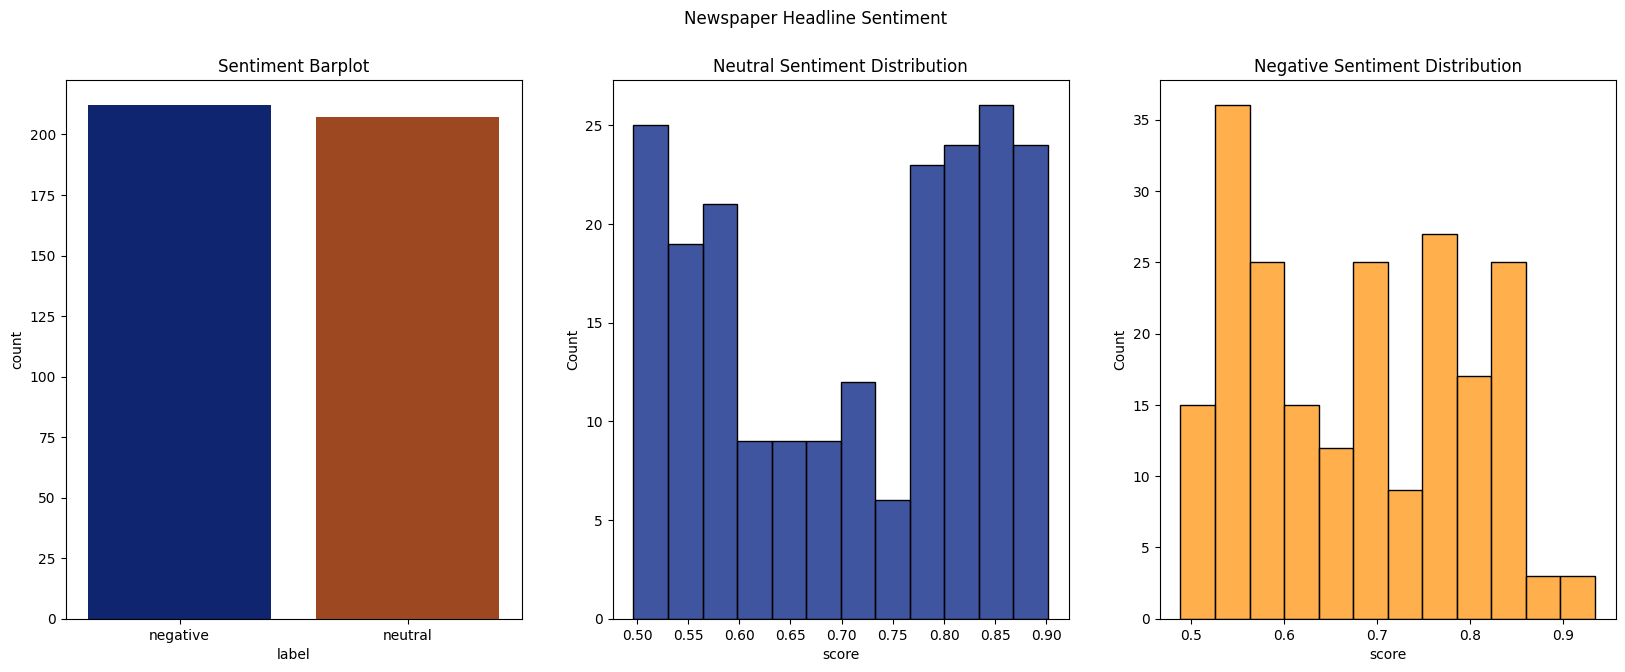

In [127]:
# Plot Sentiment
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 7))

# Barplot for categorical sentiment
sns.countplot(x='label', data=headlinesSentiment, hue='label', legend=False, palette='dark', ax=ax1)
ax1.set_title('Sentiment Barplot')


# Histogram for continuous neutral sentiment
tempDF = headlinesSentiment[headlinesSentiment['label'] == 'neutral']
sns.histplot(tempDF['score'], bins=12, color='#001c7f', ax=ax2)
ax2.set_title('Neutral Sentiment Distribution')

# Histogram for continuous negative sentiment
tempDF = headlinesSentiment[headlinesSentiment['label'] == 'negative']
sns.histplot(tempDF['score'], bins=12, color='#ff950e', ax=ax3)
ax3.set_title('Negative Sentiment Distribution')

plt.suptitle('Newspaper Headline Sentiment')
plt.savefig('Headline-Sentiment')
plt.show()

There is mostly negative and neutral headlines. The histograms tell us that neutral entries are pretty neutral, but negative headlines aren't completely negative all the time. A good amount of those records are barely pushing .8 in the negative sentiment histogram.

## Tweet Sentiment

In [27]:
# Empty dataframe for sentiment results
tweetsSentiment = pd.DataFrame(columns=['label', 'score'])
tweetsSentiment

,label,score


In [30]:
newspapersCorpusClean.head()

,Headline,Hit Sentence,Key Phrases,text,processed_text
0,Dozens of migrant men found crammed in Queens ...,"... about New York City budget, spending cuts ...","adams administration,affordable housing,baseme...",Dozens of migrant men found crammed in Queens ...,dozens migrant men found crammed queens furnit...
1,Anthony Agüero Live back in California,... seconds 15 seconds Another explosive after...,"explosive afternoon,migrants crisis",Anthony Agüero Live back in California ... sec...,anthony agero live back california seconds sec...
2,Migrants Crisis a Lifeline for New York City H...,... in the cost to shelter them. The city has ...,"adams administration,asylum seekers,budget,cit...",Migrants Crisis a Lifeline for New York City H...,migrants crisis lifeline new york city hotels ...
3,NYC Council moves to join lawsuit to force May...,... press conference hizzoner discussed recent...,"adams’ city hall counsel,city,city shelter pop...",NYC Council moves to join lawsuit to force May...,nyc council moves join lawsuit force mayor ada...
4,"The Big Weekend Show - Saturday, February 17","Civil fraud, Migrants crisis, Putin ...","civil fraud,migrants crisis","The Big Weekend Show - Saturday, February 17 C...",big weekend show saturday february civil fraud...


In [72]:
# Evaluate sentiment
for text in tweetsCorpusClean['processed_text']:
  output = getSentiment(text)
  tempDF = pd.DataFrame([output])  # single row DF to be able to add to existing DF
  tweetsSentiment = pd.concat([tweetsSentiment, tempDF], ignore_index=True)

tweetsSentiment.head()

,label,score
0,negative,0.650394
1,negative,0.731650
2,neutral,0.514357
3,negative,0.881072
4,negative,0.790705


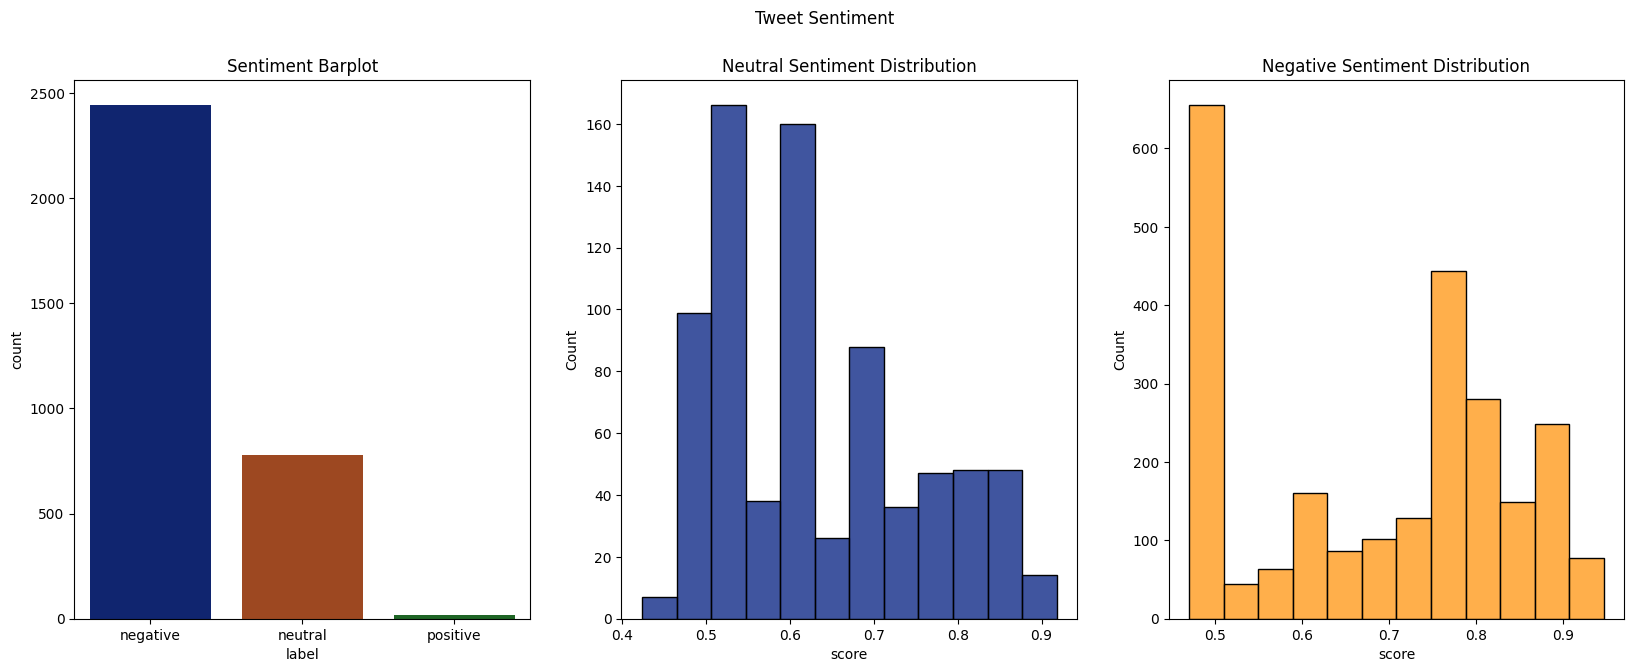

In [128]:
# Plot Sentiment
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 7))

# Barplot for categorical sentiment
sns.countplot(x='label', data=tweetsSentiment, hue='label', legend=False, palette='dark', ax=ax1)
ax1.set_title('Sentiment Barplot')


# Histogram for continuous neutral sentiment
tempDF = tweetsSentiment[tweetsSentiment['label'] == 'neutral']
sns.histplot(tempDF['score'], bins=12, color='#001c7f', ax=ax2)
ax2.set_title('Neutral Sentiment Distribution')

# Histogram for continuous negative sentiment
tempDF = tweetsSentiment[tweetsSentiment['label'] == 'negative']
sns.histplot(tempDF['score'], bins=12, color='#ff950e', ax=ax3)
ax3.set_title('Negative Sentiment Distribution')

plt.suptitle('Tweet Sentiment')
plt.savefig('Tweet-Sentiment')
plt.show()